# MODULE 3 : TIME SERIES

---

### libraries

In [1]:
import warnings
warnings.simplefilter("ignore", UserWarning)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.spatial.distance import euclidean
from collections import Counter

from sktime.datatypes._panel._convert import from_2d_array_to_nested, from_nested_to_3d_numpy, from_nested_to_multi_index, from_3d_numpy_to_multi_index, from_nested_to_2d_array

from imblearn.over_sampling import SMOTE, ADASYN

from sktime.transformations.series.boxcox import LogTransformer
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.pipeline import make_pipeline, Pipeline

from sktime.transformations.panel.reduce import Tabularizer
from sktime.transformations.panel.catch22 import Catch22
from sktime.transformations.panel.tsfresh import TSFreshFeatureExtractor

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import StratifiedShuffleSplit, RandomizedSearchCV, StratifiedKFold, cross_val_score

# 1) scikit-learn classifiers (2D inputs)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier

# 2) distance-based classifiers
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier, ProximityForest, ProximityTree

# 3) interval-based classifier
from sktime.classification.interval_based import CanonicalIntervalForest, TimeSeriesForestClassifier, DrCIF

# 4) shapelet-based classifiers
import pyts
from sktime.classification.shapelet_based import ShapeletTransformClassifier, ShapeletLearningClassifierPyts
from sktime.transformations.panel.shapelet_transform import RandomShapeletTransform
from aeon.classification.shapelet_based import RDSTClassifier

# 5) sktime dictionary-based classifiers
from sktime.classification.dictionary_based import IndividualBOSS, BOSSEnsemble, WEASEL, MUSE
from sktime.transformations.panel.dictionary_based import SFAFast
from sktime.classification.shapelet_based import MrSEQL
from aeon.classification.dictionary_based import WEASEL_V2

# 7) deep-learning classifiers
from sklearn.neural_network import MLPClassifier
from sktime.classification.deep_learning import CNNClassifier, SimpleRNNClassifier, ResNetClassifier, InceptionTimeClassifier, LSTMFCNClassifier, TapNetClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier

# 6) kernel-based classifier
from sktime.classification.kernel_based import RocketClassifier
from sktime.transformations.panel.rocket import Rocket

# 8) hybrid/meta-ensemble
from sktime.classification.hybrid import HIVECOTEV2
from aeon.classification.convolution_based import MultiRocketHydraClassifier

2025-06-22 19:13:21.438591: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


---

### api

- [omdb](http://www.omdbapi.com/)
    b34a0e63
    http://www.omdbapi.com/?i=tt3896198&apikey=b34a0e63

- [g4g](https://www.geeksforgeeks.org/python-imdbpy-searching-a-movie/)
- [idby](https://pypi.org/project/imdby/)
- [pydb](https://github.com/itsmehemant7/PyMovieDb)

---

### 0) intro

[sktime docs](https://sktime-backup.readthedocs.io/en/v0.11.4/api_reference.html)

In [2]:
"""# 1) Load the CSV
df = pd.read_csv("../../../0) dataset/0) normal dataset/imdb_ts.csv")

# 2) Identify the 100 time-series columns
time_cols = [c for c in df.columns if c.isdigit()]

# 3) Extract raw arrays & target
X_raw = df[time_cols].astype(float).values

# 5) Split BEFORE any leakage: 60% train, 20% validation, 20% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X_raw, y, test_size=0.20, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)

# 8x) 2D → nested → 3D
X_train_nested = from_2d_array_to_nested(X_train)
X_val_nested   = from_2d_array_to_nested(X_val)
X_test_nested  = from_2d_array_to_nested(X_test)
X_train_3d = from_nested_to_3d_numpy(X_train_nested)  # shape (n_train, 1, 100)
X_val_3d   = from_nested_to_3d_numpy(X_val_nested)
X_test_3d  = from_nested_to_3d_numpy(X_test_nested)
"""

'# 1) Load the CSV\ndf = pd.read_csv("../../../0) dataset/0) normal dataset/imdb_ts.csv")\n\n# 2) Identify the 100 time-series columns\ntime_cols = [c for c in df.columns if c.isdigit()]\n\n# 3) Extract raw arrays & target\nX_raw = df[time_cols].astype(float).values\n\n# 5) Split BEFORE any leakage: 60% train, 20% validation, 20% test\nX_train_val, X_test, y_train_val, y_test = train_test_split(X_raw, y, test_size=0.20, stratify=y, random_state=42)\nX_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, stratify=y_train_val, random_state=42)\n\n# 8x) 2D → nested → 3D\nX_train_nested = from_2d_array_to_nested(X_train)\nX_val_nested   = from_2d_array_to_nested(X_val)\nX_test_nested  = from_2d_array_to_nested(X_test)\nX_train_3d = from_nested_to_3d_numpy(X_train_nested)  # shape (n_train, 1, 100)\nX_val_3d   = from_nested_to_3d_numpy(X_val_nested)\nX_test_3d  = from_nested_to_3d_numpy(X_test_nested)\n'

In [3]:
"""# 1) Load the CSV
df = pd.read_csv("../../../0) dataset/3) time series preprocessed/preprocessed_no_augmentation.csv")

# 2) Identify the 100 time-series columns
time_cols = [c for c in df.columns if c.isdigit()]

# 3) Extract raw arrays
X_raw = df[time_cols].astype(float).values    # shape: (n_movies, 100)
y = df['rating_category_ord'].values

# 5) Split into train & test only (no manual val split; we'll use CV) - 80% train, 20% test (stratified)
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.20, stratify=y, random_state=42)

# 6) Convert to sktime “nested” format for TS classifiers then Convert : nested / 3D NumPy for deep‐learning models / multi index for ts
X_train_nested = from_2d_array_to_nested(X_train_raw)
X_test_nested  = from_2d_array_to_nested(X_test_raw)

X_train_3d = from_nested_to_3d_numpy(X_train_nested)  # shape: (n_train, 1, 100)
X_test_3d  = from_nested_to_3d_numpy(X_test_nested)

# 8) Verify shapes
print("After splitting & conversion:")
print(f"  X_train_raw:   {X_train_raw.shape}, y_train: {y_train.shape}")
print(f"  X_test_raw:    {X_test_raw.shape},  y_test:  {y_test.shape}")
print(f"  X_train_nested:{X_train_nested.shape}, X_test_nested: {X_test_nested.shape}")
print(f"  X_train_3d:    {X_train_3d.shape}, X_test_3d:   {X_test_3d.shape}")"""

'# 1) Load the CSV\ndf = pd.read_csv("../../../0) dataset/3) time series preprocessed/preprocessed_no_augmentation.csv")\n\n# 2) Identify the 100 time-series columns\ntime_cols = [c for c in df.columns if c.isdigit()]\n\n# 3) Extract raw arrays\nX_raw = df[time_cols].astype(float).values    # shape: (n_movies, 100)\ny = df[\'rating_category_ord\'].values\n\n# 5) Split into train & test only (no manual val split; we\'ll use CV) - 80% train, 20% test (stratified)\nX_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.20, stratify=y, random_state=42)\n\n# 6) Convert to sktime “nested” format for TS classifiers then Convert : nested / 3D NumPy for deep‐learning models / multi index for ts\nX_train_nested = from_2d_array_to_nested(X_train_raw)\nX_test_nested  = from_2d_array_to_nested(X_test_raw)\n\nX_train_3d = from_nested_to_3d_numpy(X_train_nested)  # shape: (n_train, 1, 100)\nX_test_3d  = from_nested_to_3d_numpy(X_test_nested)\n\n# 8) Verify shapes\nprint("Af

In [4]:
# 1) Load the CSV
df = pd.read_csv("../../../0) dataset/3) time series preprocessed/preprocessed_no_augmentation.csv")

# 2) Identify the 100 time-series columns
time_cols = [c for c in df.columns if c.isdigit()]

# 3) Extract raw arrays
X_raw = df[time_cols].astype(float).values    # shape: (n_movies, 100)

# 3b) Create the new ordinal target:
#    low & medium low → 0
#    medium          → 1
#    medium high     → 2
#    high            → 3
mapping = {
    "Low": 0,
    "Medium Low": 0,
    "Medium": 1,
    "Medium High": 2,
    "High": 3,
}
df["rating_category_ord"] = df["rating_category"].map(mapping)
y = df["rating_category_ord"].values            # now in {0,1,2,3}

# 4) Split into train & test only (80% train, 20% test), stratified on the new y
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.20, stratify=y, random_state=42,)

# 5) Convert to sktime formats:
#    - nested (for sktime TS classifiers)
#    - 3D numpy (for deep‐learning models)
X_train_nested = from_2d_array_to_nested(X_train_raw)
X_test_nested  = from_2d_array_to_nested(X_test_raw)

X_train_3d = from_nested_to_3d_numpy(X_train_nested)  # (n_train, 1, 100)
X_test_3d  = from_nested_to_3d_numpy(X_test_nested)   # (n_test,  1, 100)

# 6) Verify shapes and classes
print("After splitting & conversion:")
print(f"  X_train_raw:    {X_train_raw.shape}, y_train: {y_train.shape}, classes: {np.unique(y_train)}")
print(f"  X_test_raw:     {X_test_raw.shape},  y_test:  {y_test.shape},  classes: {np.unique(y_test)}")
print(f"  X_train_nested: {X_train_nested.shape}")
print(f"  X_train_3d:     {X_train_3d.shape}")
print(f"  X_test_3d:      {X_test_3d.shape}")

After splitting & conversion:
  X_train_raw:    (907, 51), y_train: (907,), classes: [0 1 2 3]
  X_test_raw:     (227, 51),  y_test:  (227,),  classes: [0 1 2 3]
  X_train_nested: (907, 1)
  X_train_3d:     (907, 1, 51)
  X_test_3d:      (227, 1, 51)


'rating_category' Class Distribution (Complete): {0: 138, 1: 387, 2: 232, 3: 377}


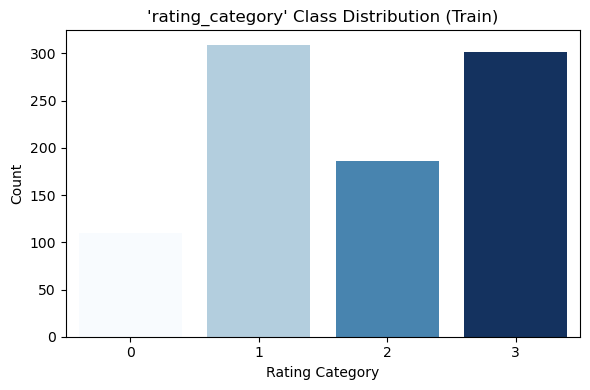

In [5]:
# 3) Prit overall distribution
counts_dict = pd.Series(y).value_counts().sort_index().to_dict()
print("'rating_category' Class Distribution (Complete):", counts_dict)

# 4) Plot train distribution in the desired order
target_counts = pd.Series(y_train).value_counts()
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index, palette='Blues', legend=False)
plt.xlabel("Rating Category")
plt.ylabel("Count")
plt.title("'rating_category' Class Distribution (Train)")
plt.tight_layout()
plt.show()

[SMOTE docs](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)

[ADASYN docs](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.ADASYN.html)

In [6]:
"""# --- 3) Set up ADASYN to oversample only class 0 up to 200 samples ---
# smote = SMOTE(sampling_strategy={0: 200}, random_state=42)
adasyn = ADASYN(sampling_strategy="minority", random_state=42)
X_res, y_res = adasyn.fit_resample(X_train_raw, y_train)
print("After ADASYN-only-class0, training distribution:", Counter(y_res))

# --- 4) Plot train distribution in the desired order ---
target_counts = pd.Series(y_res).value_counts().sort_index()
plt.figure(figsize=(6, 4))
sns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index, palette='Blues', legend=False)
plt.xlabel("Rating Category")
plt.ylabel("Count")
plt.title("'rating_category' Class Distribution after ADASYN (Train)")
plt.tight_layout()
plt.show()"""

'# --- 3) Set up ADASYN to oversample only class 0 up to 200 samples ---\n# smote = SMOTE(sampling_strategy={0: 200}, random_state=42)\nadasyn = ADASYN(sampling_strategy="minority", random_state=42)\nX_res, y_res = adasyn.fit_resample(X_train_raw, y_train)\nprint("After ADASYN-only-class0, training distribution:", Counter(y_res))\n\n# --- 4) Plot train distribution in the desired order ---\ntarget_counts = pd.Series(y_res).value_counts().sort_index()\nplt.figure(figsize=(6, 4))\nsns.barplot(x=target_counts.index, y=target_counts.values, hue=target_counts.index, palette=\'Blues\', legend=False)\nplt.xlabel("Rating Category")\nplt.ylabel("Count")\nplt.title("\'rating_category\' Class Distribution after ADASYN (Train)")\nplt.tight_layout()\nplt.show()'

---

### 1) instance based models

### 1.1) KNeighborsClassifier

[knn docs](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters (CV): {'n_neighbors': 30, 'metric': 'euclidean'}
Best CV accuracy: 0.5039

=== KNeighborsClassifier Test Classification Report ===
              precision    recall  f1-score   support

           0       0.38      0.18      0.24        28
           1       0.43      0.69      0.53        78
           2       0.40      0.04      0.08        46
           3       0.63      0.71      0.67        75

    accuracy                           0.50       227
   macro avg       0.46      0.41      0.38       227
weighted avg       0.49      0.50      0.45       227



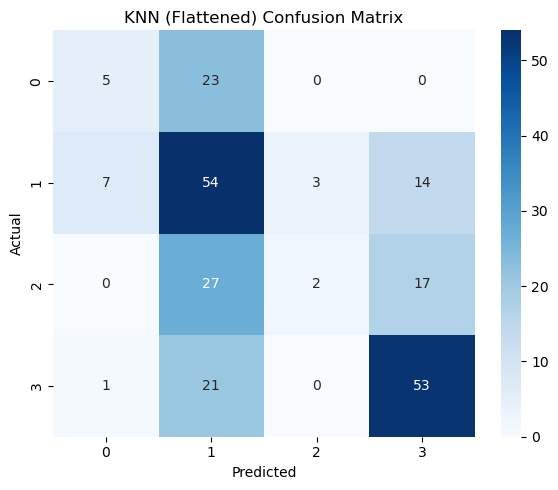

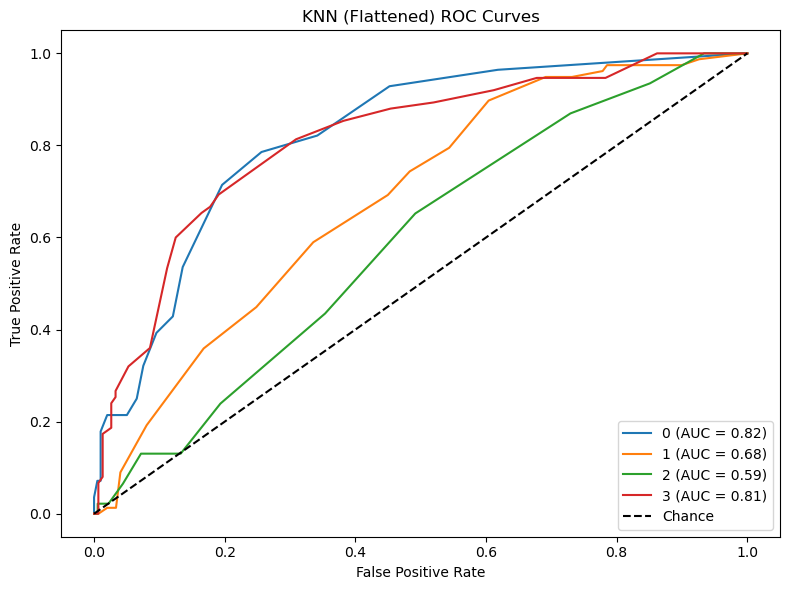

In [7]:
# =============================================================================
# PART X: KNeighborsClassifier with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space ---
param_dist = {
    "n_neighbors": [10, 20, 25, 30],
    "metric": ["euclidean", "manhattan"]
}

# --- 2) Set up RandomizedSearchCV ---
rs = RandomizedSearchCV(
    estimator=KNeighborsClassifier(),
    param_distributions=param_dist,
    n_iter=8,
    scoring="accuracy",    # f1_weighted
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search ---
rs.fit(X_train_raw, y_train)
#rs.fit(X_res, y_res)
print(f"Best parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_knn = rs.best_estimator_
y_pred = best_knn.predict(X_test_raw)

print("\n=== KNeighborsClassifier Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_knn.classes_, yticklabels=best_knn.classes_)
plt.title("KNN (Flattened) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_knn.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_knn.predict_proba(X_test_raw)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("KNN (Flattened) ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 1.2) KNeighborsTimeSeriesClassifier

[knnts docs](https://sktime-backup.readthedocs.io/en/v0.11.4/api_reference/auto_generated/sktime.classification.distance_based.KNeighborsTimeSeriesClassifier.html)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters (CV): {'n_neighbors': 20, 'distance_params': {'window': 0.9}}
Best CV accuracy: 0.5127

=== DTW-kNN (k=20, window=0.9) Classification Report ===
              precision    recall  f1-score   support

           0       0.33      0.18      0.23        28
           1       0.46      0.69      0.55        78
           2       0.25      0.07      0.10        46
           3       0.65      0.71      0.68        75

    accuracy                           0.51       227
   macro avg       0.42      0.41      0.39       227
weighted avg       0.46      0.51      0.46       227



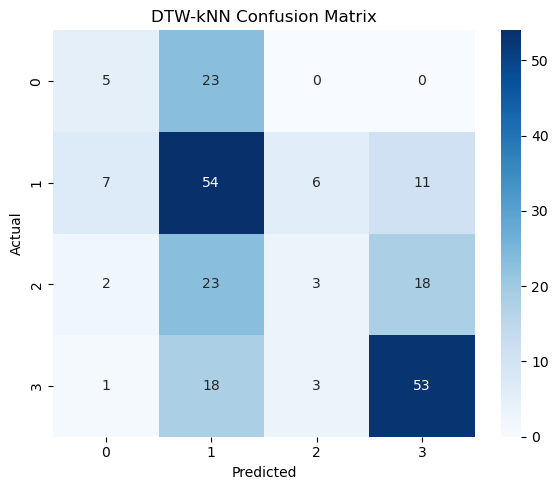

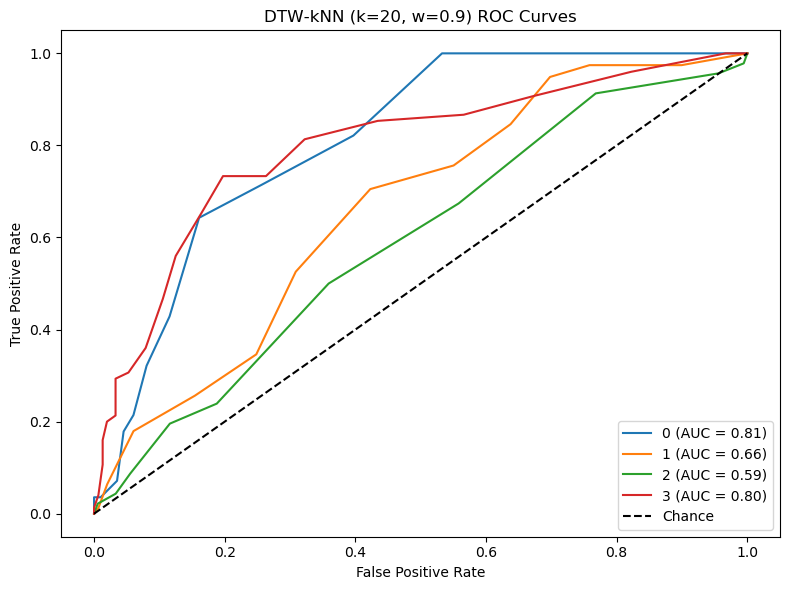

In [8]:
# =============================================================================
# PART X+1: DTW‐kNN with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space ---
param_dist = {
    "n_neighbors": [10, 20, 25, 30],
    "distance_params": [{"window": 0.1}, {"window": 0.5}, {"window": 0.9}]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=KNeighborsTimeSeriesClassifier(distance="dtw", n_jobs=-1),
    param_distributions=param_dist,
    n_iter=10,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_knn_dtw = rs.best_estimator_
y_pred = best_knn_dtw.predict(X_test_nested)

print(f"\n=== DTW-kNN (k={best_knn_dtw.n_neighbors}, window={best_knn_dtw.distance_params['window']}) Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_knn_dtw.classes_, yticklabels=best_knn_dtw.classes_)
plt.title(f"DTW-kNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_knn_dtw.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_knn_dtw.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title(f"DTW‐kNN (k={best_knn_dtw.n_neighbors}, w={best_knn_dtw.distance_params['window']}) ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 2) linear models

### 2.1) LogisticRegressor

[lr docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

### 3) tree based "normal" models

### 3.1) DecisionTreeClassifier

[dt docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters (CV): {'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 5, 'criterion': 'gini', 'class_weight': None}
Best CV accuracy: 0.4774

=== Decision Tree Test Classification Report ===
              precision    recall  f1-score   support

           0       0.47      0.25      0.33        28
           1       0.47      0.72      0.57        78
           2       0.27      0.09      0.13        46
           3       0.58      0.60      0.59        75

    accuracy                           0.49       227
   macro avg       0.45      0.41      0.40       227
weighted avg       0.47      0.49      0.46       227



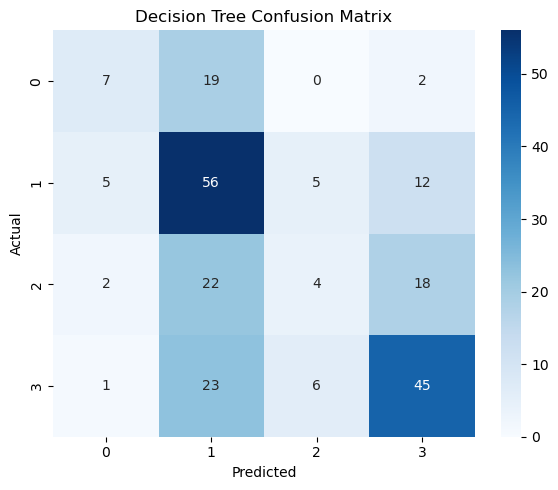

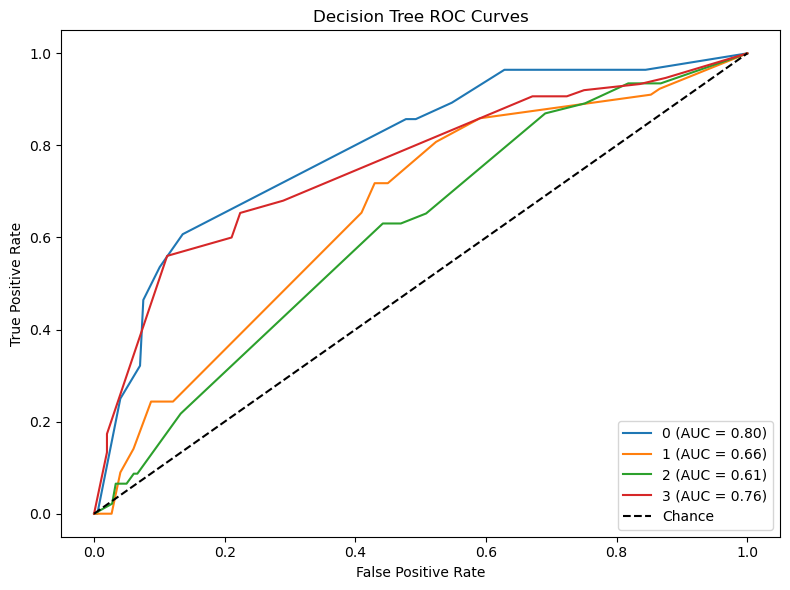

In [9]:
# =============================================================================
# PART Y: DecisionTreeClassifier with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space ---
param_dist = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 10, 20],
    "min_samples_split": [2, 5, 10, 20, 50],
    "min_samples_leaf": [1, 2, 5, 10],
    "class_weight": [None, "balanced"]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the training set ---
rs.fit(X_train_raw, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_dt = rs.best_estimator_
y_pred = best_dt.predict(X_test_raw)

print("\n=== Decision Tree Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_dt.classes_, yticklabels=best_dt.classes_)
plt.title("Decision Tree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_dt.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_dt.predict_proba(X_test_raw)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("Decision Tree ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 30 candidates, totalling 150 fits

Best parameters (CV): {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 5, 'criterion': 'entropy', 'class_weight': None}
Best CV accuracy: 0.4609

=== Decision Tree on Catch22 Features Test Classification Report ===
              precision    recall  f1-score   support

           0       0.36      0.18      0.24        28
           1       0.46      0.67      0.54        78
           2       0.00      0.00      0.00        46
           3       0.54      0.69      0.61        75

    accuracy                           0.48       227
   macro avg       0.34      0.38      0.35       227
weighted avg       0.38      0.48      0.42       227



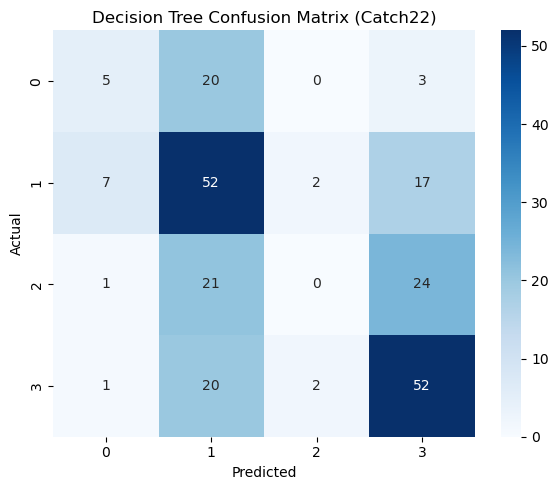

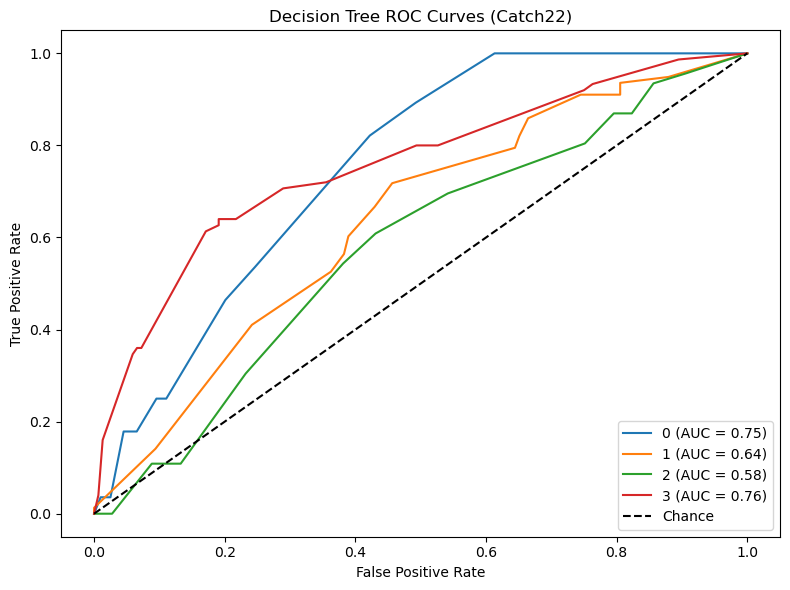

In [10]:
# =============================================================================
# PART Z: DecisionTreeClassifier on Catch22 Features with RandomizedSearchCV
# =============================================================================

# --- 1) Extract Catch22 features ---
catch22 = Catch22()
X_train_c22 = catch22.fit_transform(X_train_nested, y_train)  # shape: (n_train, 22)
X_test_c22  = catch22.transform(X_test_nested)

# --- 2) Define hyperparameter search space ---
param_dist = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 10, 20, 50],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "class_weight": [None, "balanced"]
}

# --- 3) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 4) Run search on the Catch22‐transformed training set ---
rs.fit(X_train_c22, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 5) Final evaluation on the test set ---
best_dt_c22 = rs.best_estimator_
y_pred = best_dt_c22.predict(X_test_c22)

print("\n=== Decision Tree on Catch22 Features Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 6) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=best_dt_c22.classes_,
    yticklabels=best_dt_c22.classes_
)
plt.title("Decision Tree Confusion Matrix (Catch22)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 7) ROC Curve & AUC (Multiclass) ---
classes = best_dt_c22.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_dt_c22.predict_proba(X_test_c22)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("Decision Tree ROC Curves (Catch22)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [11]:
"""# =============================================================================
# DecisionTreeClassifier on TSFresh Features with RandomizedSearchCV
# =============================================================================

# --- 1) Extract TSFresh features ---
tsfresh = TSFreshFeatureExtractor(default_fc_parameters="efficient")
X_train_tf = tsfresh.fit_transform(X_train_nested, y_train)
X_test_tf  = tsfresh.transform(X_test_nested)

# --- 2) Define hyperparameter search space ---
param_dist = {
    "criterion": ["gini", "entropy"],
    "max_depth": [None, 5, 10, 20, 50],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 8],
    "class_weight": [None, "balanced"]
}

# --- 3) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=30,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 4) Run search on the TSFresh‐transformed training set ---
rs.fit(X_train_tf, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 5) Final evaluation on the test set ---
best_dt_tf = rs.best_estimator_
y_pred = best_dt_tf.predict(X_test_tf)

print("\n=== Decision Tree on TSFresh Features Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 6) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=best_dt_tf.classes_,
    yticklabels=best_dt_tf.classes_
)
plt.title("Decision Tree Confusion Matrix (TSFresh)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 7) ROC Curve & AUC (Multiclass) ---
classes = best_dt_tf.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_dt_tf.predict_proba(X_test_tf)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("Decision Tree ROC Curves (TSFresh)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()"""

'# =============================================================================\n# DecisionTreeClassifier on TSFresh Features with RandomizedSearchCV\n# =============================================================================\n\n# --- 1) Extract TSFresh features ---\ntsfresh = TSFreshFeatureExtractor(default_fc_parameters="efficient")\nX_train_tf = tsfresh.fit_transform(X_train_nested, y_train)\nX_test_tf  = tsfresh.transform(X_test_nested)\n\n# --- 2) Define hyperparameter search space ---\nparam_dist = {\n    "criterion": ["gini", "entropy"],\n    "max_depth": [None, 5, 10, 20, 50],\n    "min_samples_split": [2, 5, 10, 20],\n    "min_samples_leaf": [1, 2, 4, 8],\n    "class_weight": [None, "balanced"]\n}\n\n# --- 3) Set up RandomizedSearchCV with stratified folds ---\nrs = RandomizedSearchCV(\n    estimator=DecisionTreeClassifier(random_state=42),\n    param_distributions=param_dist,\n    n_iter=30,\n    scoring="accuracy",\n    cv=StratifiedKFold(n_splits=5, shuffle=True, rand

### 3.2) RandomForestClassifier

[rf docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters (CV): {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': 10, 'class_weight': None}
Best CV accuracy: 0.4984

=== RandomForest (Raw Series) Test Classification Report ===
              precision    recall  f1-score   support

           0       0.39      0.25      0.30        28
           1       0.44      0.72      0.55        78
           2       0.18      0.04      0.07        46
           3       0.66      0.63      0.64        75

    accuracy                           0.49       227
   macro avg       0.42      0.41      0.39       227
weighted avg       0.46      0.49      0.45       227



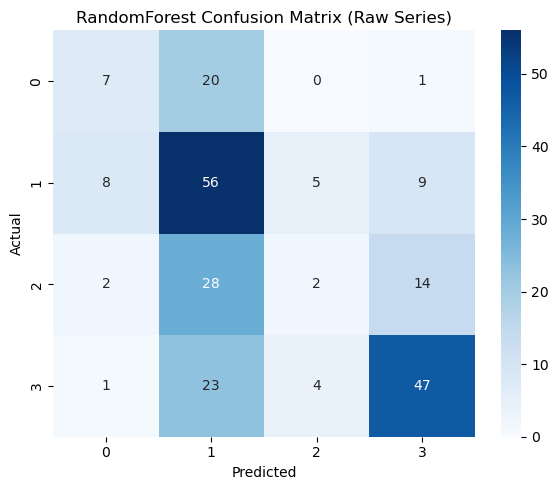

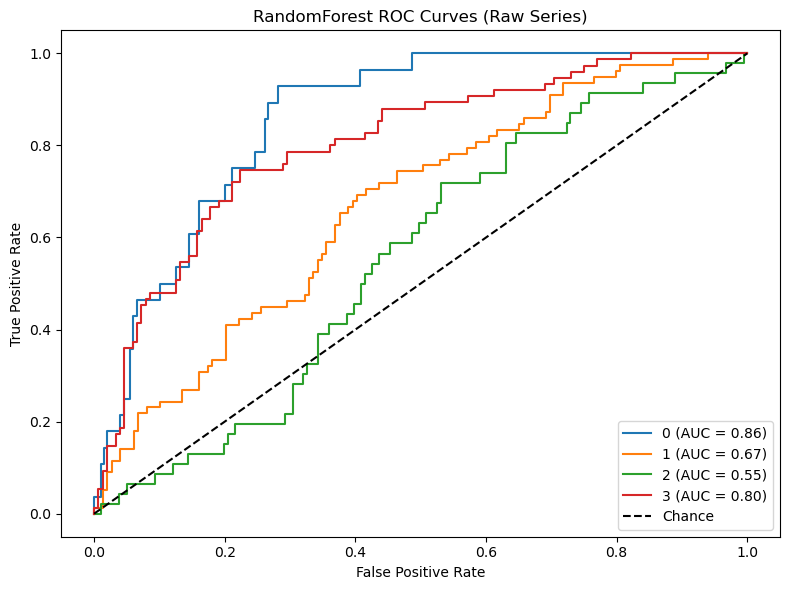

In [12]:
# =============================================================================
# PART Z++: RandomForestClassifier on Raw Flattened Series with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space ---
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": [None, "balanced"]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the raw training set ---
rs.fit(X_train_raw, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_rf_raw = rs.best_estimator_
y_pred = best_rf_raw.predict(X_test_raw)

print("\n=== RandomForest (Raw Series) Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_rf_raw.classes_, yticklabels=best_rf_raw.classes_)
plt.title("RandomForest Confusion Matrix (Raw Series)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_rf_raw.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_rf_raw.predict_proba(X_test_raw)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("RandomForest ROC Curves (Raw Series)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters (CV): {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 5, 'class_weight': None}
Best CV accuracy: 0.4973

=== Catch22 + RandomForest Test Classification Report ===
              precision    recall  f1-score   support

           0       0.36      0.14      0.21        28
           1       0.45      0.77      0.57        78
           2       0.00      0.00      0.00        46
           3       0.63      0.69      0.66        75

    accuracy                           0.51       227
   macro avg       0.36      0.40      0.36       227
weighted avg       0.41      0.51      0.44       227



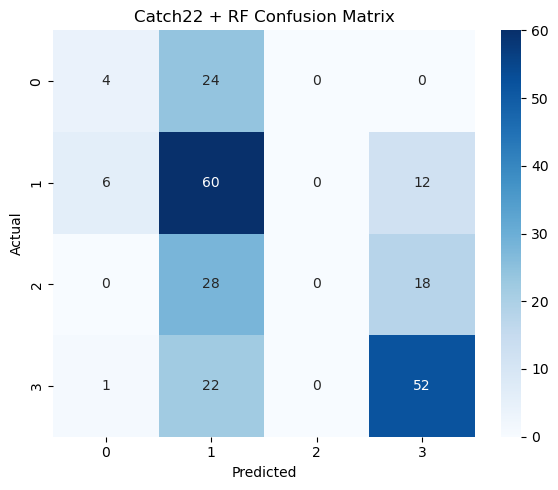

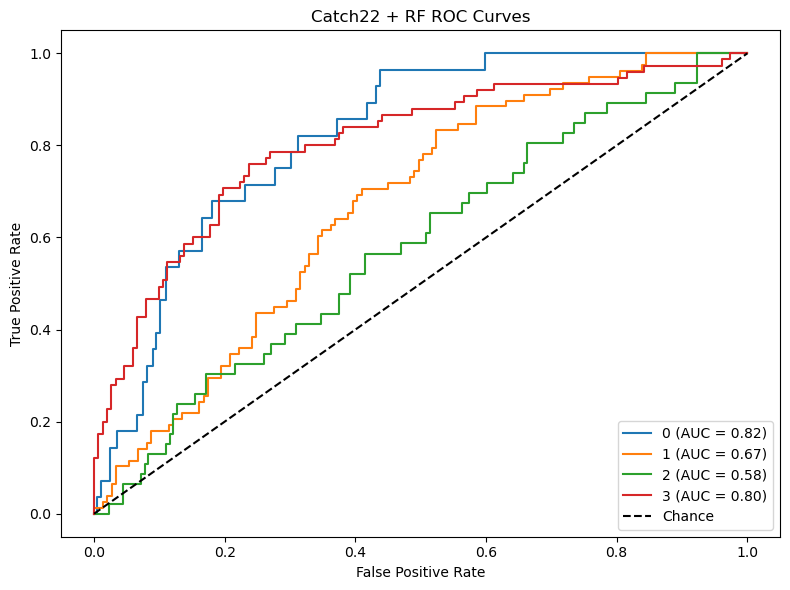

In [13]:
# =============================================================================
# PART Z+: Catch22 → RandomForestClassifier with RandomizedSearchCV
# =============================================================================

# --- 1) Extract Catch22 features ---
catch22 = Catch22()
X_train_c22 = catch22.fit_transform(X_train_nested, y_train)  # shape: (n_train, 22)
X_test_c22  = catch22.transform(X_test_nested)

# --- 2) Define hyperparameter search space ---
param_dist = {
    "n_estimators": [100, 200, 300, 500],
    "max_depth": [None, 5, 10, 20, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "class_weight": [None, "balanced"]
}

# --- 3) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 4) Run search on the Catch22‐transformed training set ---
rs.fit(X_train_c22, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 5) Final evaluation on the test set ---
best_rf_c22 = rs.best_estimator_
y_pred = best_rf_c22.predict(X_test_c22)

print("\n=== Catch22 + RandomForest Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 6) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_rf_c22.classes_, yticklabels=best_rf_c22.classes_)
plt.title("Catch22 + RF Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 7) ROC Curve & AUC (Multiclass) ---
classes = best_rf_c22.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_rf_c22.predict_proba(X_test_c22)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("Catch22 + RF ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 3.3) AdaBoostClassifier

[ab docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best parameters (CV): {'n_estimators': 300, 'learning_rate': 1.5}
Best CV accuracy: 0.4962

=== AdaBoost (DT base) Test Classification Report ===
              precision    recall  f1-score   support

           0       0.33      0.18      0.23        28
           1       0.43      0.64      0.52        78
           2       0.14      0.07      0.09        46
           3       0.63      0.63      0.63        75

    accuracy                           0.46       227
   macro avg       0.38      0.38      0.37       227
weighted avg       0.43      0.46      0.43       227



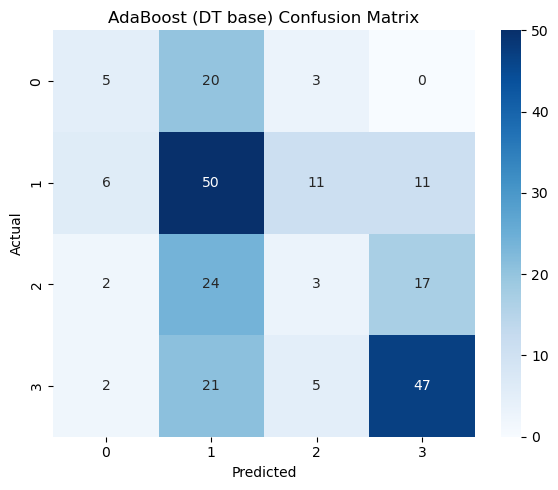

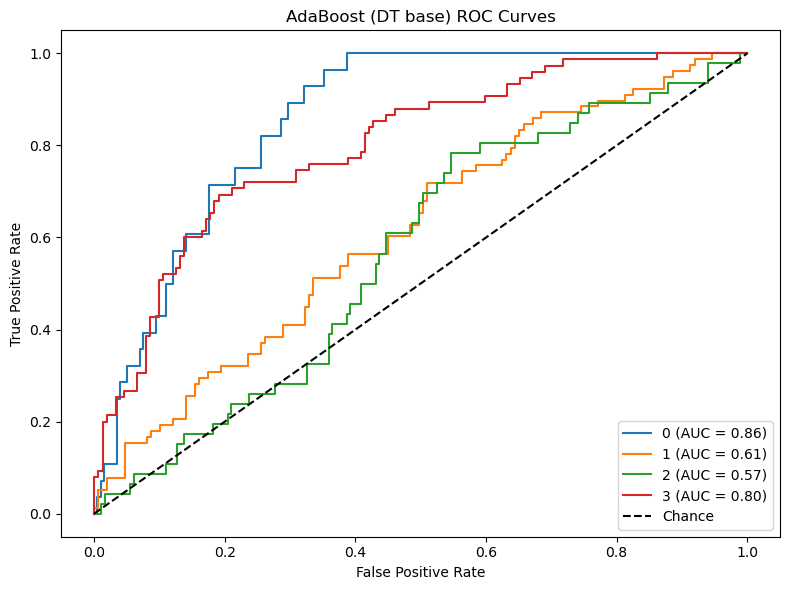

In [14]:
# =============================================================================
# PART N: AdaBoostClassifier with DecisionTree base via RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space ---
param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "learning_rate": [0.5, 1.0, 1.5],
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5, random_state=42), random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the raw training set ---
rs.fit(X_train_raw, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_ada = rs.best_estimator_
y_pred = best_ada.predict(X_test_raw)

print("\n=== AdaBoost (DT base) Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_ada.classes_, yticklabels=best_ada.classes_)
plt.title("AdaBoost (DT base) Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_ada.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_ada.predict_proba(X_test_raw)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("AdaBoost (DT base) ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [15]:
"""# =============================================================================
# AdaBoostClassifier (DT base) on Catch22 Features with RandomizedSearchCV
# =============================================================================

# --- 1) Extract Catch22 features ---
catch22 = Catch22()
X_train_c22 = catch22.fit_transform(X_train_nested, y_train)
X_test_c22  = catch22.transform(X_test_nested)
X_train_c22 = X_train_c22.drop(columns=["# 4", "# 21"])
X_test_c22 = X_test_c22.drop(columns=['4', '21'])

# --- 2) Define hyperparameter search space ---
param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "learning_rate": [0.5, 1.0, 1.5],
}

# --- 3) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5, random_state=42), random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 4) Run search on the Catch22 training set ---
rs.fit(X_train_c22, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 5) Final evaluation on the test set ---
best_ada_c22 = rs.best_estimator_
y_pred = best_ada_c22.predict(X_test_c22)

print("\n=== AdaBoost (DT base) on Catch22 Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 6) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_ada_c22.classes_, yticklabels=best_ada_c22.classes_)
plt.title("AdaBoost (DT base) Confusion Matrix (Catch22)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 7) ROC Curve & AUC (Multiclass) ---
classes = best_ada_c22.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_ada_c22.predict_proba(X_test_c22)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("AdaBoost (DT base) ROC Curves (Catch22)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()"""

'# =============================================================================\n# AdaBoostClassifier (DT base) on Catch22 Features with RandomizedSearchCV\n# =============================================================================\n\n# --- 1) Extract Catch22 features ---\ncatch22 = Catch22()\nX_train_c22 = catch22.fit_transform(X_train_nested, y_train)\nX_test_c22  = catch22.transform(X_test_nested)\nX_train_c22 = X_train_c22.drop(columns=["# 4", "# 21"])\nX_test_c22 = X_test_c22.drop(columns=[\'4\', \'21\'])\n\n# --- 2) Define hyperparameter search space ---\nparam_dist = {\n    "n_estimators": [50, 100, 200, 300],\n    "learning_rate": [0.5, 1.0, 1.5],\n}\n\n# --- 3) Set up RandomizedSearchCV with stratified folds ---\nrs = RandomizedSearchCV(\n    estimator=AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=5, random_state=42), random_state=42),\n    param_distributions=param_dist,\n    n_iter=10,\n    scoring="accuracy",\n    cv=StratifiedKFold(n_splits=5, shuffle

### 3.4) HistGradientBoostingClassifier

[hgbm docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingClassifier.html)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best parameters (CV): {'min_samples_leaf': 100, 'max_iter': 100, 'max_depth': 10, 'learning_rate': 0.01, 'l2_regularization': 0.1}
Best CV accuracy: 0.5083

=== HistGradientBoostingClassifier Test Classification Report ===
              precision    recall  f1-score   support

           0       0.42      0.18      0.25        28
           1       0.46      0.79      0.58        78
           2       0.00      0.00      0.00        46
           3       0.65      0.65      0.65        75

    accuracy                           0.51       227
   macro avg       0.38      0.41      0.37       227
weighted avg       0.43      0.51      0.45       227



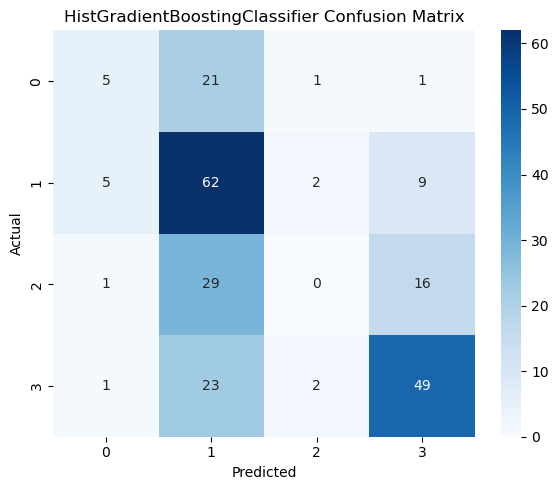

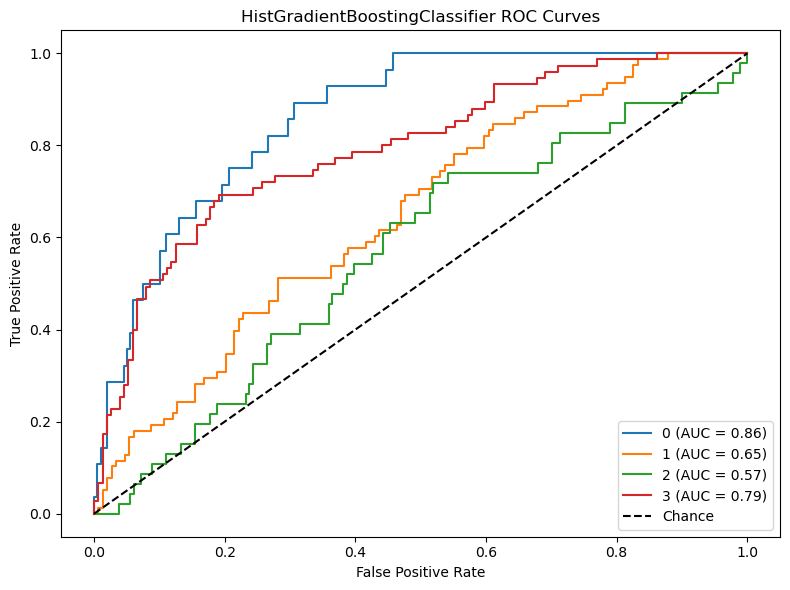

In [16]:
# =============================================================================
# PART M: HistGradientBoostingClassifier with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space ---
param_dist = {
    "learning_rate": [0.01, 0.1, 0.2, 0.3],
    "max_iter": [100, 200, 300],
    "max_depth": [None, 3, 5, 10],
    "min_samples_leaf": [20, 50, 100],
    "l2_regularization": [0.0, 0.1, 1.0]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=HistGradientBoostingClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the raw training set ---
rs.fit(X_train_raw, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_hgb = rs.best_estimator_
y_pred = best_hgb.predict(X_test_raw)

print("\n=== HistGradientBoostingClassifier Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_hgb.classes_, yticklabels=best_hgb.classes_)
plt.title("HistGradientBoostingClassifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_hgb.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_hgb.predict_proba(X_test_raw)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("HistGradientBoostingClassifier ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 4) tree based "ts" models

### 4.1) ProximityTree

[pxt docs](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.classification.distance_based.ProximityTree.html)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.



Best parameters (CV): {'max_depth': 10, 'distance_measure': 'dtw'}
Best CV accuracy: 0.1312

=== ProximityTree Test Classification Report ===
              precision    recall  f1-score   support

           0       0.12      0.93      0.22        28
           1       0.60      0.08      0.14        78
           2       0.00      0.00      0.00        46
           3       0.00      0.00      0.00        75

    accuracy                           0.14       227
   macro avg       0.18      0.25      0.09       227
weighted avg       0.22      0.14      0.07       227



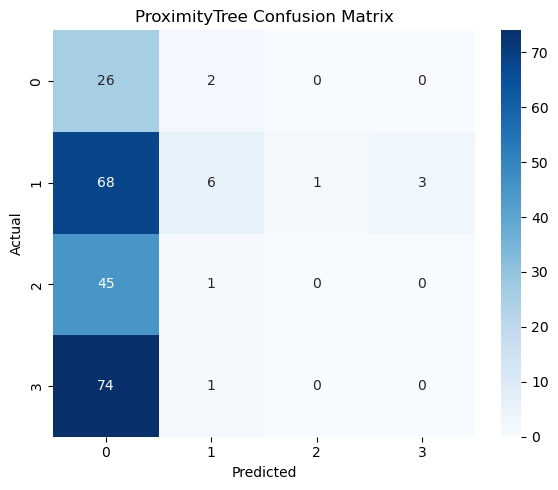

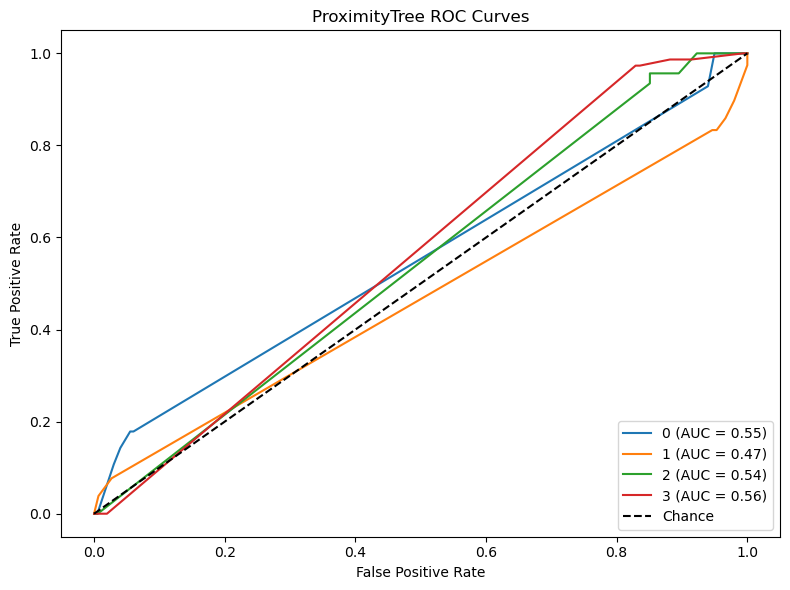

In [48]:
# =============================================================================
# PART A: “ProximityTree” via ProximityTree
# =============================================================================

# --- 1) Define hyperparameter search space ---
param_dist = {
    "distance_measure": ["dtw"],
    "max_depth": [10]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=ProximityTree(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=1,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_pt = rs.best_estimator_
y_pred = best_pt.predict(X_test_nested)

print("\n=== ProximityTree Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_pt.classes_, yticklabels=best_pt.classes_)
plt.title("ProximityTree Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_pt.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_pt.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("ProximityTree ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 4.2) ProximityForest

[pxf docs](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.classification.distance_based.ProximityForest.html#proximityforest)

In [ ]:
"""# =============================================================================
# PART A: ProximityForest with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space ---
param_dist = {
    "n_estimators": [5, 10, 50, 100],
    "distance_measure": ["dtw"],
    "max_depth": [5]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=ProximityForest(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_pf = rs.best_estimator_
y_pred = best_pf.predict(X_test_nested)

print("\n=== ProximityForest Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_pf.classes_, yticklabels=best_pf.classes_)
plt.title("ProximityForest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_pf.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_pf.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("ProximityForest ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()"""

'# =============================================================================\n# PART A: ProximityForest with RandomizedSearchCV\n# =============================================================================\n\n# --- 1) Define hyperparameter search space ---\nparam_dist = {\n    "n_estimators": [5, 10, 50, 100],\n    "distance_measure": ["euclidean", "dtw"],\n    "max_depth": [None, 5, 10, 20]\n}\n\n# --- 2) Set up RandomizedSearchCV with stratified folds ---\nrs = RandomizedSearchCV(\n    estimator=ProximityForest(random_state=42, n_jobs=-1),\n    param_distributions=param_dist,\n    n_iter=20,\n    scoring="accuracy",\n    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),\n    random_state=42,\n    n_jobs=-1,\n    verbose=1\n)\n\n# --- 3) Run search on the nested training set ---\nrs.fit(X_train_nested, y_train)\nprint(f"\nBest parameters (CV): {rs.best_params_}")\nprint(f"Best CV accuracy: {rs.best_score_:.4f}")\n\n# --- 4) Final evaluation on the test set ---\nbes

### 4.3) CanonicalIntervalForest

[ci docs](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.classification.interval_based.CanonicalIntervalForest.html)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/anaconda3/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._tran


Best parameters (CV): {'n_intervals': None, 'n_estimators': 100, 'min_interval': 3, 'max_interval': None, 'base_estimator': 'DTC'}
Best CV accuracy: 0.5117


/opt/anaconda3/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._tran


=== CanonicalIntervalForest Test Classification Report ===
              precision    recall  f1-score   support

           0       0.44      0.25      0.32        28
           1       0.45      0.73      0.56        78
           2       0.00      0.00      0.00        46
           3       0.62      0.64      0.63        75

    accuracy                           0.49       227
   macro avg       0.38      0.41      0.38       227
weighted avg       0.41      0.49      0.44       227



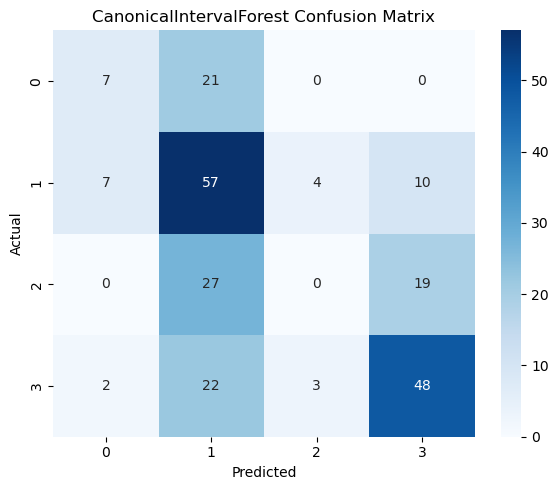

/opt/anaconda3/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._transform_single_feature, the argument case_id is deprecated and will be removed in the future.
  warn(
/opt/anaconda3/lib/python3.12/site-packages/sktime/transformations/panel/catch22.py:390: FutureWarning: In Catch22._tran

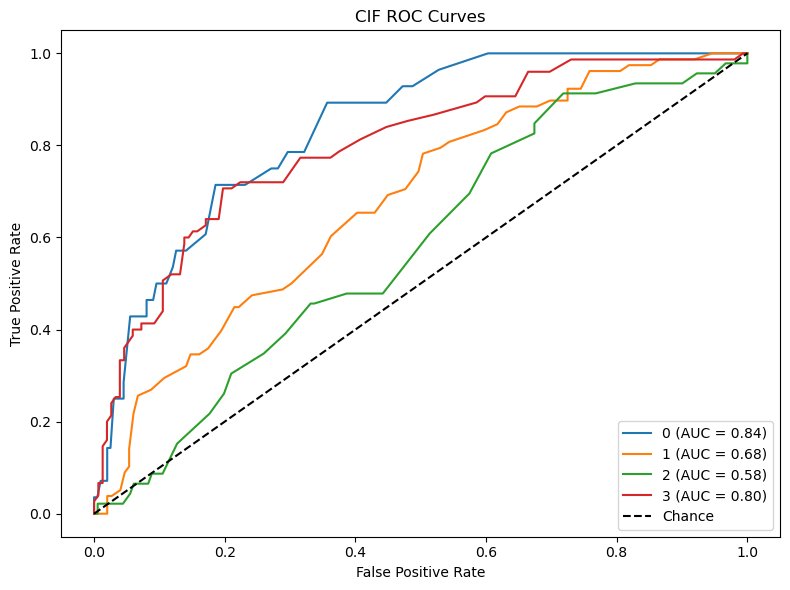

In [19]:
# =============================================================================
# CanonicalIntervalForest on Raw Nested Series with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space for CIF ---
param_dist = {
    "n_estimators": [100, 200, 300],
    "n_intervals": [None],
    "min_interval": [3],
    "max_interval": [None, 7, 14],
    "base_estimator": ["DTC", "CIT"]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=CanonicalIntervalForest(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=1,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_cif = rs.best_estimator_
y_pred = best_cif.predict(X_test_nested)

print("\n=== CanonicalIntervalForest Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_cif.classes_, yticklabels=best_cif.classes_)
plt.title("CanonicalIntervalForest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_cif.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_cif.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("CIF ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 4.5) DrCIF

[dr docs](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.classification.interval_based.DrCIF.html)

In [20]:
"""# =============================================================================
# PART C: DrCIF (Diverse‐Representation CIF) with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space for DrCIF ---
param_dist = {
    "n_estimators": [100, 200, 300],
    "n_intervals": [None],
    "min_interval": [4],
    "max_interval": [None, 7, 14],
    "base_estimator": ["DTC", "CIT"]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=DrCIF(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=1,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_drcif = rs.best_estimator_
y_pred = best_drcif.predict(X_test_nested)

print("\n=== DrCIF Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=best_drcif.classes_,
    yticklabels=best_drcif.classes_
)
plt.title("DrCIF Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_drcif.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_drcif.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("DrCIF ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
"""

'# =============================================================================\n# PART C: DrCIF (Diverse‐Representation CIF) with RandomizedSearchCV\n# =============================================================================\n\n# --- 1) Define hyperparameter search space for DrCIF ---\nparam_dist = {\n    "n_estimators": [100, 200, 300],\n    "n_intervals": [None],\n    "min_interval": [4],\n    "max_interval": [None, 7, 14],\n    "base_estimator": ["DTC", "CIT"]\n}\n\n# --- 2) Set up RandomizedSearchCV with stratified folds ---\nrs = RandomizedSearchCV(\n    estimator=DrCIF(random_state=42, n_jobs=-1),\n    param_distributions=param_dist,\n    n_iter=1,\n    scoring="accuracy",\n    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),\n    random_state=42,\n    n_jobs=-1,\n    verbose=1\n)\n\n# --- 3) Run search on the nested training set ---\nrs.fit(X_train_nested, y_train)\nprint(f"\nBest parameters (CV): {rs.best_params_}")\nprint(f"Best CV accuracy: {rs.best_score

### 4.6) TimeSeriesForestClassifier

[tsfc docs](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.classification.interval_based.TimeSeriesForestClassifier.html)

Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best parameters (CV): {'n_estimators': 200, 'min_interval': 3}
Best CV accuracy: 0.5017

=== TimeSeriesForestClassifier Test Classification Report ===
              precision    recall  f1-score   support

           0       0.42      0.36      0.38        28
           1       0.48      0.69      0.57        78
           2       0.17      0.04      0.07        46
           3       0.62      0.64      0.63        75

    accuracy                           0.50       227
   macro avg       0.42      0.43      0.41       227
weighted avg       0.45      0.50      0.46       227



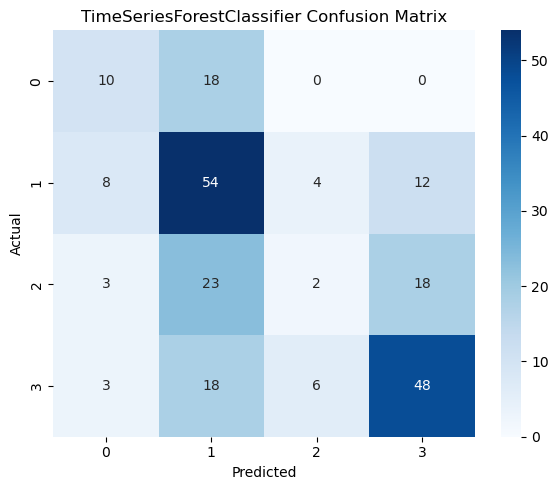

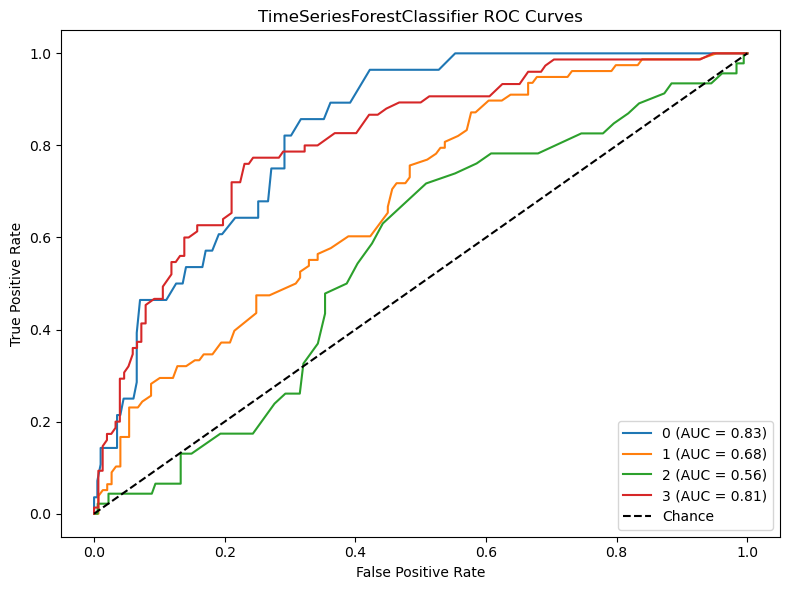

In [21]:
# =============================================================================
# PART B: TimeSeriesForestClassifier with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space ---
param_dist = {
    "n_estimators": [100, 200, 300],
    "min_interval": [3, 7, 14]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=TimeSeriesForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=5,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_tsf = rs.best_estimator_
y_pred = best_tsf.predict(X_test_nested)

print("\n=== TimeSeriesForestClassifier Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_tsf.classes_, yticklabels=best_tsf.classes_)
plt.title("TimeSeriesForestClassifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_tsf.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_tsf.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("TimeSeriesForestClassifier ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 5) shapelets

### 5.1) ShapeletTransformClassifier

[shap docs](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.classification.shapelet_based.ShapeletTransformClassifier.html)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  war


[STC] Best parameters (CV): {'n_shapelet_samples': 10000, 'max_shapelets': None, 'max_shapelet_length': None}
[STC] Best CV accuracy: 0.4432


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



=== ShapeletTransformClassifier Test Classification Report ===
              precision    recall  f1-score   support

           0       0.29      0.14      0.19        28
           1       0.40      0.64      0.49        78
           2       0.29      0.11      0.16        46
           3       0.50      0.47      0.48        75

    accuracy                           0.41       227
   macro avg       0.37      0.34      0.33       227
weighted avg       0.40      0.41      0.38       227



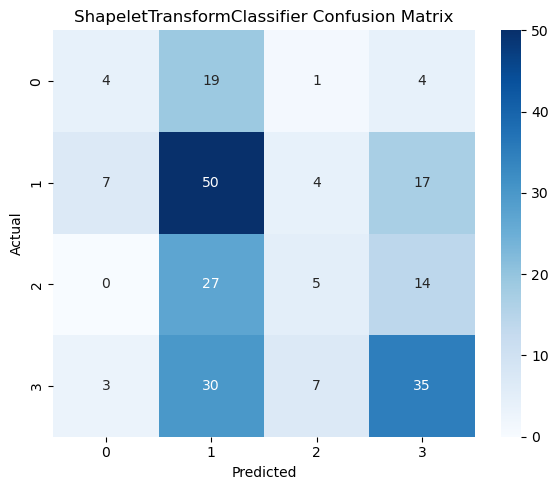

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


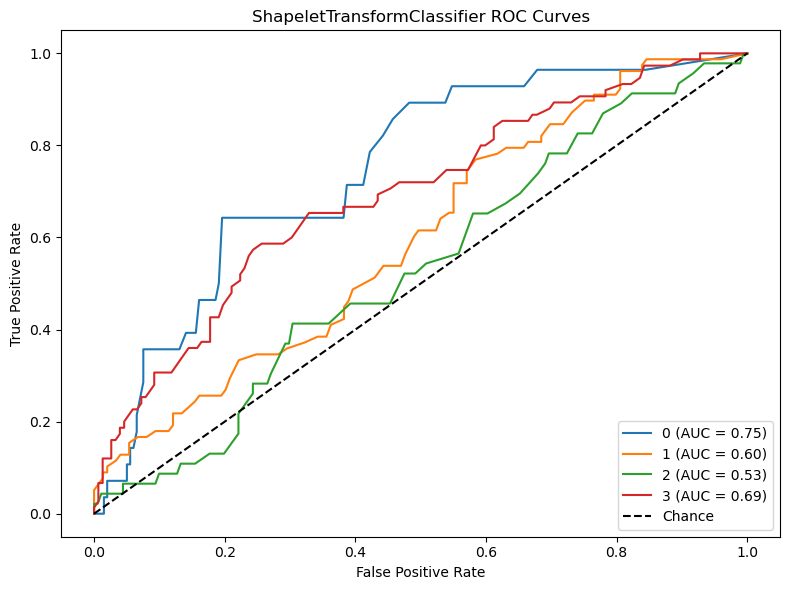

In [22]:
# =============================================================================
# ShapeletTransformClassifier with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space for STC ---
param_dist_stc = {
    "n_shapelet_samples": [10000],
    "max_shapelets": [None],
    "max_shapelet_length": [None]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs_stc = RandomizedSearchCV(
    estimator=ShapeletTransformClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist_stc,
    n_iter=1,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs_stc.fit(X_train_nested, y_train)
print(f"\n[STC] Best parameters (CV): {rs_stc.best_params_}")
print(f"[STC] Best CV accuracy: {rs_stc.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_stc = rs_stc.best_estimator_
y_pred_stc = best_stc.predict(X_test_nested)

print("\n=== ShapeletTransformClassifier Test Classification Report ===")
print(classification_report(y_test, y_pred_stc))

# --- 5) Confusion Matrix ---
cm_stc = confusion_matrix(y_test, y_pred_stc)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_stc, annot=True, fmt="d", cmap="Blues", xticklabels=best_stc.classes_, yticklabels=best_stc.classes_)
plt.title("ShapeletTransformClassifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes_stc = best_stc.classes_
y_test_bin_stc = label_binarize(y_test, classes=classes_stc)
y_score_stc = best_stc.predict_proba(X_test_nested)

fpr_stc, tpr_stc, roc_auc_stc = {}, {}, {}
for i, cls in enumerate(classes_stc):
    fpr_stc[i], tpr_stc[i], _ = roc_curve(y_test_bin_stc[:, i], y_score_stc[:, i])
    roc_auc_stc[i] = auc(fpr_stc[i], tpr_stc[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes_stc):
    plt.plot(fpr_stc[i], tpr_stc[i], label=f"{cls} (AUC = {roc_auc_stc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("ShapeletTransformClassifier ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 5.2) RandomShapeletTransform

[randshap docs](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.panel.shapelet_transform.RandomShapeletTransform.html)

Fitting 2 folds for each of 2 candidates, totalling 4 fits

[RST+DT] Best parameters (CV): {'rst__remove_self_similar': True, 'rst__n_shapelet_samples': 1000, 'rst__min_shapelet_length': 3, 'rst__max_shapelet_length': 8}
[RST+DT] Best CV accuracy: 0.4311

=== RandomShapeletTransform + KNN Classification Report ===
              precision    recall  f1-score   support

           0       0.67      0.07      0.13        28
           1       0.43      0.65      0.52        78
           2       0.20      0.11      0.14        46
           3       0.51      0.55      0.53        75

    accuracy                           0.44       227
   macro avg       0.45      0.35      0.33       227
weighted avg       0.44      0.44      0.40       227



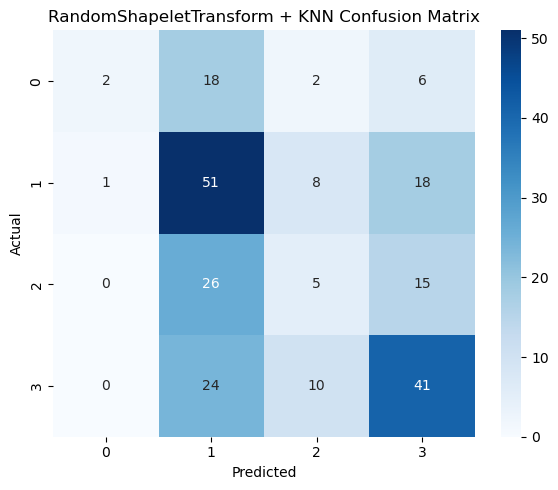

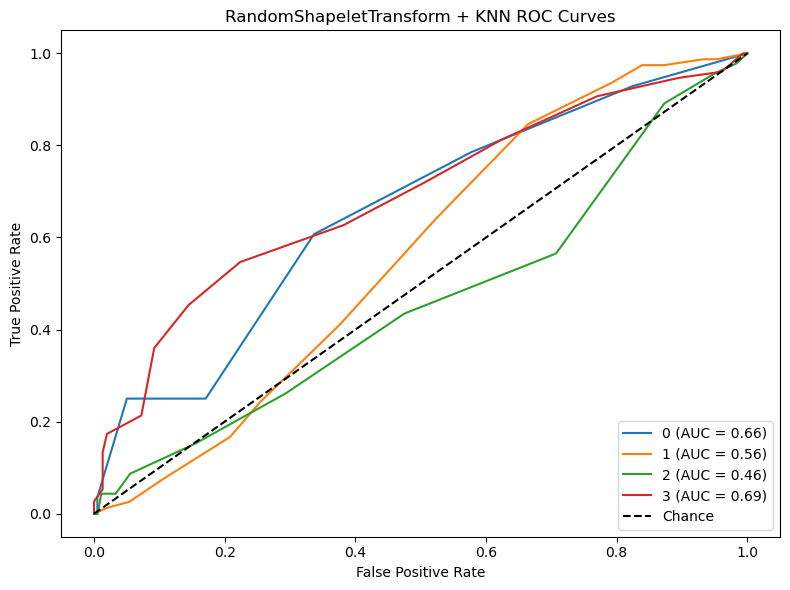

In [9]:
# =============================================================================
# RandomShapeletTransform + DecisionTreeClassifier with RandomizedSearchCV
# =============================================================================

# --- 2) Define hyperparameter search space ---
param_dist_rst = {
    "rst__n_shapelet_samples": [1000],
    #"rst__max_shapelets": [None],
    "rst__min_shapelet_length": [3],
    "rst__max_shapelet_length": [8, 15],
    "rst__remove_self_similar": [True]
}

# --- 3) Set up RandomizedSearchCV with stratified folds ---
rs_rst = RandomizedSearchCV(
    estimator=Pipeline([("rst", RandomShapeletTransform(random_state=42, n_jobs=-1)), ("clf", KNeighborsClassifier(n_neighbors=20, metric="manhattan"))]),
    param_distributions=param_dist_rst,
    n_iter=2,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 4) Run search on the nested training set ---
rs_rst.fit(X_train_nested, y_train)
print(f"\n[RST+DT] Best parameters (CV): {rs_rst.best_params_}")
print(f"[RST+DT] Best CV accuracy: {rs_rst.best_score_:.4f}")

# --- 5) Final evaluation on the test set ---
best_rst = rs_rst.best_estimator_
y_pred_rst = best_rst.predict(X_test_nested)

print("\n=== RandomShapeletTransform + KNN Classification Report ===")
print(classification_report(y_test, y_pred_rst))

# --- 6) Confusion Matrix ---
cm_rst = confusion_matrix(y_test, y_pred_rst)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rst, annot=True, fmt="d", cmap="Blues", xticklabels=best_rst.named_steps["clf"].classes_, yticklabels=best_rst.named_steps["clf"].classes_)
plt.title("RandomShapeletTransform + KNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 7) ROC Curve & AUC (Multiclass) ---
classes_rst = best_rst.named_steps["clf"].classes_
y_test_bin_rst = label_binarize(y_test, classes=classes_rst)
y_score_rst = best_rst.predict_proba(X_test_nested)

fpr_rst, tpr_rst, roc_auc_rst = {}, {}, {}
for i, cls in enumerate(classes_rst):
    fpr_rst[i], tpr_rst[i], _ = roc_curve(y_test_bin_rst[:, i], y_score_rst[:, i])
    roc_auc_rst[i] = auc(fpr_rst[i], tpr_rst[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes_rst):
    plt.plot(fpr_rst[i], tpr_rst[i], label=f"{cls} (AUC = {roc_auc_rst[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("RandomShapeletTransform + KNN ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 5.2.1) Check the Shapelets


Shapelet metadata summary:
           length   info_gain
count  810.000000  810.000000
mean     5.091358    0.010100
std      1.365856    0.009803
min      3.000000    0.002524
25%      4.000000    0.005154
50%      5.000000    0.007250
75%      6.000000    0.011211
max      7.000000    0.080400


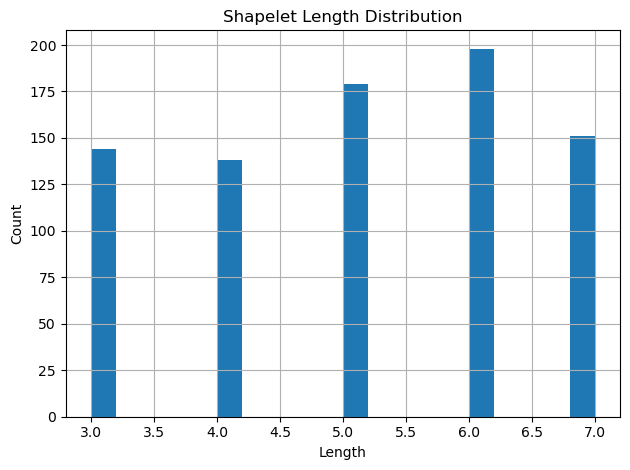

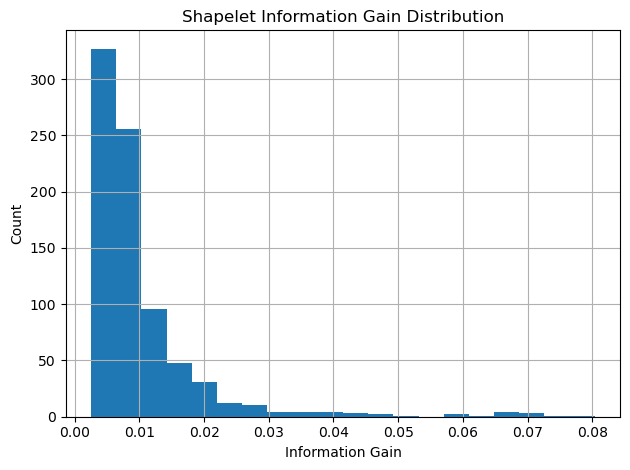

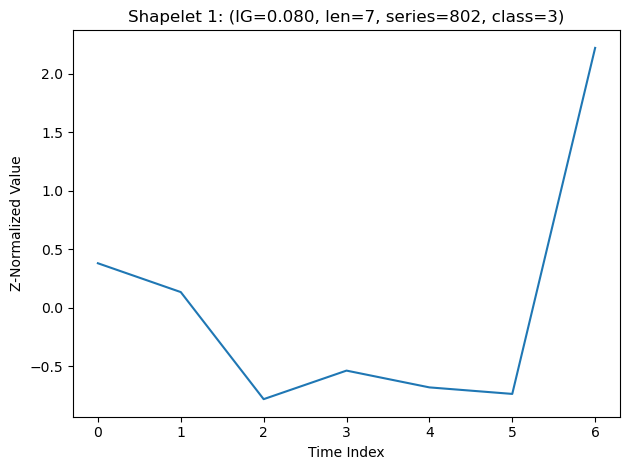

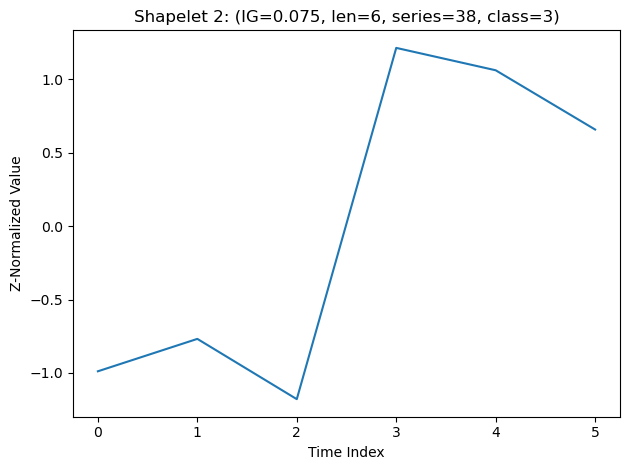

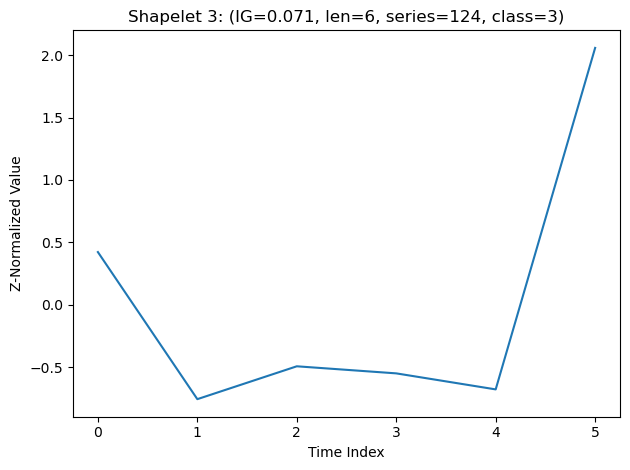

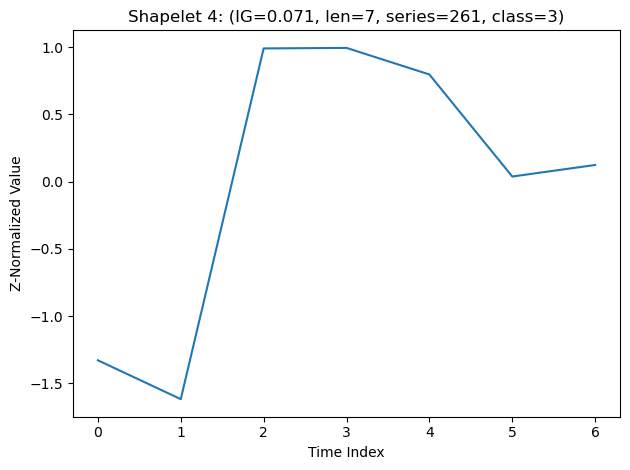

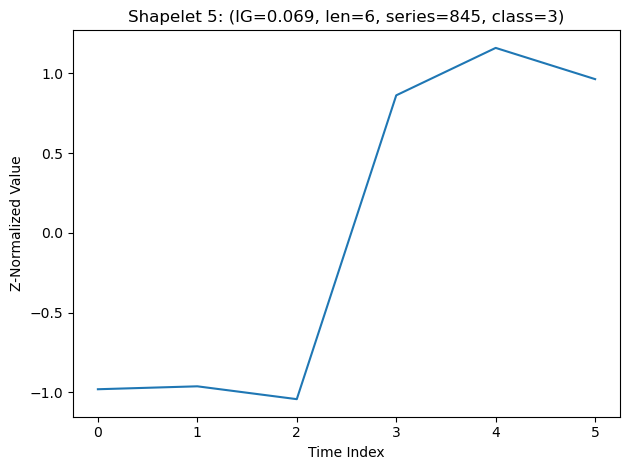

In [10]:
# =============================================================================
# 8) Inspect the learned shapelets from your RST+DT pipeline
# =============================================================================

# a) Grab the fitted shapelet transformer
rst_transformer = best_rst.named_steps["rst"]

# b) Pull out its shapelets (info_gain, length, start_pos, dim, series_id, class_id, values_array)
shapelets = rst_transformer.shapelets

# c) Build a pandas DataFrame of metadata + raw subsequences
df_shapelets = pd.DataFrame(
    shapelets,
    columns=[
        "info_gain",    # discriminative power
        "length",       # subsequence length
        "start_pos",    # index in the original series
        "dim",          # for multivariate, which dimension
        "series_id",    # which series it came from
        "class_id",     # the class it was most predictive for
        "values"        # the z-normalized subsequence array
    ]
)

print("\nShapelet metadata summary:")
print(df_shapelets[["length", "info_gain"]].describe())

plt.figure()
df_shapelets["length"].hist(bins=20)
plt.title("Shapelet Length Distribution")
plt.xlabel("Length")
plt.ylabel("Count")
plt.tight_layout()

plt.figure()
df_shapelets["info_gain"].hist(bins=20)
plt.title("Shapelet Information Gain Distribution")
plt.xlabel("Information Gain")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# e) Visualize the top-K shapelets by info_gain
topk = 5
top_idx = df_shapelets.nlargest(topk, "info_gain").index

for rank, idx in enumerate(top_idx, start=1):
    vals = df_shapelets.at[idx, "values"]
    ig   = df_shapelets.at[idx, "info_gain"]
    ln   = df_shapelets.at[idx, "length"]
    sid  = df_shapelets.at[idx, "series_id"]
    cid  = df_shapelets.at[idx, "class_id"]
    plt.figure()
    plt.plot(vals)
    plt.title(f"Shapelet {rank}: (IG={ig:.3f}, len={ln}, " f"series={sid}, class={cid})")
    plt.xlabel("Time Index")
    plt.ylabel("Z-Normalized Value")
    plt.tight_layout()
    plt.show()

### 5.3) ShapeletLearningClassifierPyts

[pyts docs](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.classification.shapelet_based.ShapeletLearningClassifierPyts.html)

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameters (CV): {'shapelet_scale': 3, 'n_shapelets_per_size': 0.2, 'min_shapelet_length': 0.1, 'max_iter': 1000, 'loss': 'crossentropy', 'learning_rate': 1.0, 'alpha': -100, 'C': 1000}
Best CV accuracy: 0.3737

=== ShapeletLearningClassifierPyts Test Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.37      0.99      0.54        78
           2       0.00      0.00      0.00        46
           3       0.84      0.21      0.34        75

    accuracy                           0.41       227
   macro avg       0.30      0.30      0.22       227
weighted avg       0.41      0.41      0.30       227



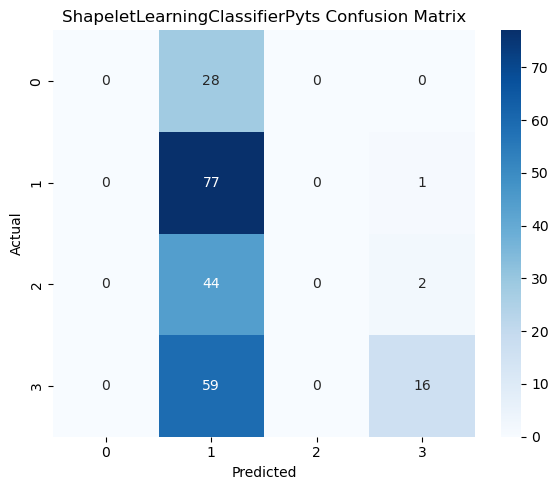

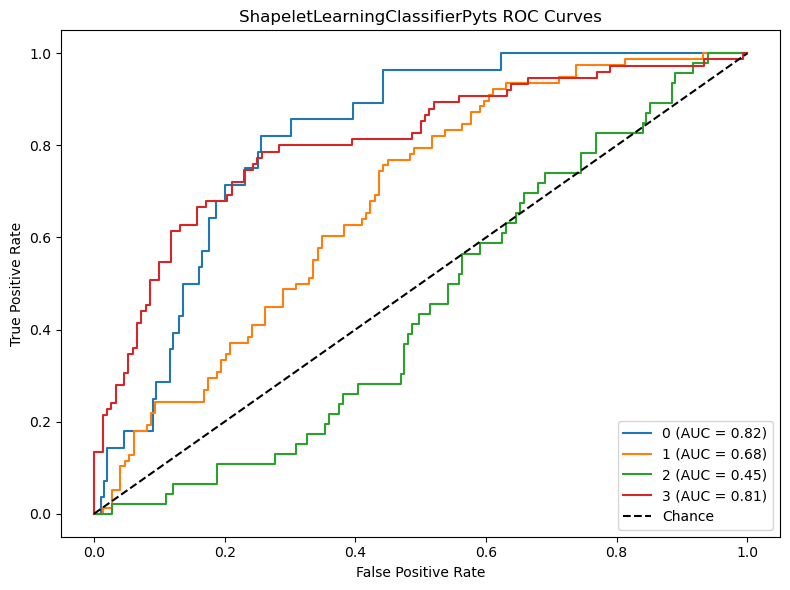

In [25]:
# =============================================================================
# ShapeletLearningClassifierPyts with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space ---
param_dist = {
    "loss": ["softmax", "crossentropy"],
    "n_shapelets_per_size": [0.2],
    "min_shapelet_length": [0.1],
    "shapelet_scale": [3],
    "C": [1000],
    "learning_rate": [1.0],
    "max_iter": [1000],
    "alpha": [-100]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=ShapeletLearningClassifierPyts(random_state=42, verbose=0),
    param_distributions=param_dist,
    n_iter=1,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
# Note: ShapeletLearningClassifierPyts expects nested input directly
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_slc = rs.best_estimator_
y_pred_slc = best_slc.predict(X_test_nested)

print("\n=== ShapeletLearningClassifierPyts Test Classification Report ===")
print(classification_report(y_test, y_pred_slc))

# --- 5) Confusion Matrix ---
cm_slc = confusion_matrix(y_test, y_pred_slc)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_slc, annot=True, fmt="d", cmap="Blues", xticklabels=best_slc.classes_, yticklabels=best_slc.classes_)
plt.title("ShapeletLearningClassifierPyts Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes_slc = best_slc.classes_
y_test_bin_slc = label_binarize(y_test, classes=classes_slc)
y_score_slc = best_slc.predict_proba(X_test_nested)

fpr_slc, tpr_slc, roc_auc_slc = {}, {}, {}
for i, cls in enumerate(classes_slc):
    fpr_slc[i], tpr_slc[i], _ = roc_curve(y_test_bin_slc[:, i], y_score_slc[:, i])
    roc_auc_slc[i] = auc(fpr_slc[i], tpr_slc[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes_slc):
    plt.plot(fpr_slc[i], tpr_slc[i], label=f"{cls} (AUC = {roc_auc_slc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("ShapeletLearningClassifierPyts ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [26]:
"""# =============================================================================
# PART: Analyze Retrieved Shapelets from ShapeletTransformClassifier
# =============================================================================

# --- 0) Assume `best_stc`, `X_train_nested`, `y_train` are already defined ---

# 1) Extract all learned shapelets from the fitted ShapeletTransformClassifier
#    Each entry is a tuple; we only need the first five entries:
#    (series_id, start, length, quality, shapelet_array, <possibly extra items>...)
shapelets_info = best_slc.shapelets_

# 2) Sort shapelets by quality (descending) and pick the top K
K = 5
# Sort by element[3] (quality)
sorted_shapelets = sorted(shapelets_info, key=lambda x: x[3], reverse=True)
topK = sorted_shapelets[:K]

# 3) Convert nested training set to 2D array for overlaying and matching
#    from_nested_to_2d_array returns shape (n_train, series_length)
X_train_2d = from_nested_to_2d_array(X_train_nested)

# 4) Plot the top K shapelets alone (index by [4] for the array)
plt.figure(figsize=(12, 8))
for i, shapelet_tuple in enumerate(topK):
    series_id = shapelet_tuple[0]
    start     = shapelet_tuple[1]
    length    = shapelet_tuple[2]
    quality   = shapelet_tuple[3]
    shp       = shapelet_tuple[4]  # the actual 1D numpy array

    plt.subplot(2, (K + 1) // 2, i + 1)
    plt.plot(shp, linewidth=2, color="red")
    plt.title(
        f"Shapelet {i+1}\n"
        f"src_series={series_id}, start={start}, len={length}\n"
        f"quality={quality:.3f}"
    )
    plt.xlabel("Time step within shapelet")
    plt.tight_layout()

plt.suptitle("Top K Learned Shapelets", y=1.02, fontsize=16)
plt.show()


# 5) For each top shapelet: overlay on its “parent” full series and highlight the window
for i, shapelet_tuple in enumerate(topK):
    series_id = shapelet_tuple[0]
    start     = shapelet_tuple[1]
    length    = shapelet_tuple[2]
    quality   = shapelet_tuple[3]
    shp       = shapelet_tuple[4]

    full_series = X_train_2d[series_id]  # length = 100

    plt.figure(figsize=(8, 4))
    plt.plot(full_series, label=f"Full series #{series_id}", color="gray", alpha=0.5)
    plt.plot(
        np.arange(start, start + length),
        shp,
        label="Learned Shapelet",
        color="red",
        linewidth=2
    )
    plt.axvspan(start, start + length - 1, color="red", alpha=0.2)
    plt.xlabel("Day (0–99)")
    plt.ylabel("Preprocessed Gross")
    plt.title(
        f"Shapelet {i+1} overlaid on its parent series\n"
        f"(series {series_id}, days {start}-{start+length-1}, quality={quality:.3f})"
    )
    plt.legend()
    plt.tight_layout()
    plt.show()


# 6) Define a helper to find closest matches for a given shapelet among a target class
def find_closest_matches(shapelet, start, length, X2d, y_labels, target_class, top_k=3):
    idxs = np.where(y_labels == target_class)[0]
    dist_list = []
    for idx in idxs:
        candidate = X2d[idx][start : start + length]
        # only compute distance if the extracted window has correct length
        if len(candidate) == length:
            d = euclidean(shapelet, candidate)
            dist_list.append((idx, d))
    dist_list = sorted(dist_list, key=lambda x: x[1])[:top_k]
    return dist_list  # list of (idx, distance)


# 7) For each top shapelet, find and plot closest matches in each class
unique_classes = np.unique(y_train)
for i, shapelet_tuple in enumerate(topK):
    series_id = shapelet_tuple[0]
    start     = shapelet_tuple[1]
    length    = shapelet_tuple[2]
    quality   = shapelet_tuple[3]
    shp       = shapelet_tuple[4]

    print(f"\n--- Shapelet {i+1}: src_series={series_id}, start={start}, length={length}, quality={quality:.3f} ---")
    for cls in unique_classes:
        matches = find_closest_matches(shp, start, length, X_train_2d, y_train, target_class=cls, top_k=2)
        print(f"  Class {cls} closest matches:", matches)

        # Plot the top match from this class
        if matches:
            match_idx, dist = matches[0]
            candidate = X_train_2d[match_idx]

            plt.figure(figsize=(6, 3))
            plt.plot(candidate, color="gray", alpha=0.3, label=f"Series #{match_idx} (class {cls})")
            plt.plot(
                np.arange(start, start + length),
                shp,
                color="red",
                linewidth=2,
                label=f"Shapelet {i+1} (ref)\nDist={dist:.2f}"
            )
            plt.axvspan(start, start + length - 1, color="red", alpha=0.2)
            plt.title(f"Closest match for class {cls}")
            plt.xlabel("Day")
            plt.ylabel("Preprocessed Gross")
            plt.legend(loc="upper right", fontsize=8)
            plt.tight_layout()
            plt.show()

"""

'# =============================================================================\n# PART: Analyze Retrieved Shapelets from ShapeletTransformClassifier\n# =============================================================================\n\n# --- 0) Assume `best_stc`, `X_train_nested`, `y_train` are already defined ---\n\n# 1) Extract all learned shapelets from the fitted ShapeletTransformClassifier\n#    Each entry is a tuple; we only need the first five entries:\n#    (series_id, start, length, quality, shapelet_array, <possibly extra items>...)\nshapelets_info = best_slc.shapelets_\n\n# 2) Sort shapelets by quality (descending) and pick the top K\nK = 5\n# Sort by element[3] (quality)\nsorted_shapelets = sorted(shapelets_info, key=lambda x: x[3], reverse=True)\ntopK = sorted_shapelets[:K]\n\n# 3) Convert nested training set to 2D array for overlaying and matching\n#    from_nested_to_2d_array returns shape (n_train, series_length)\nX_train_2d = from_nested_to_2d_array(X_train_nested)\n\n#

### 5.4) RDSTClassifier

[rdst docs](https://www.aeon-toolkit.org/en/latest/api_reference/auto_generated/aeon.classification.shapelet_based.RDSTClassifier.html)

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameters (CV): {'shapelet_lengths': None, 'proba_normalization': 0.8, 'max_shapelets': 10000, 'estimator': None, 'alpha_similarity': 0.5}
Best CV accuracy: 0.4785

=== RDSTClassifier Test Classification Report ===
              precision    recall  f1-score   support

           0       0.35      0.21      0.27        28
           1       0.45      0.67      0.54        78
           2       0.25      0.09      0.13        46
           3       0.63      0.67      0.65        75

    accuracy                           0.49       227
   macro avg       0.42      0.41      0.40       227
weighted avg       0.46      0.49      0.46       227



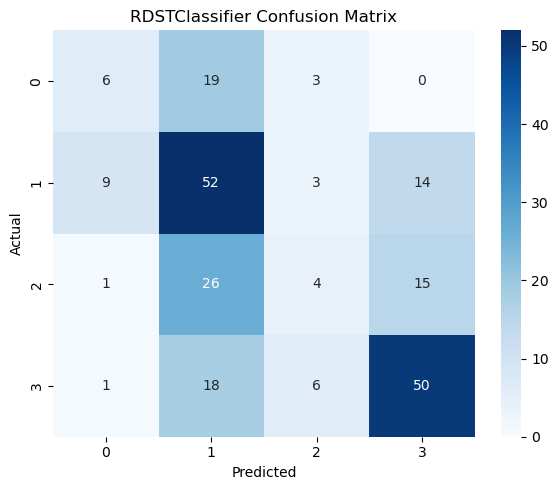

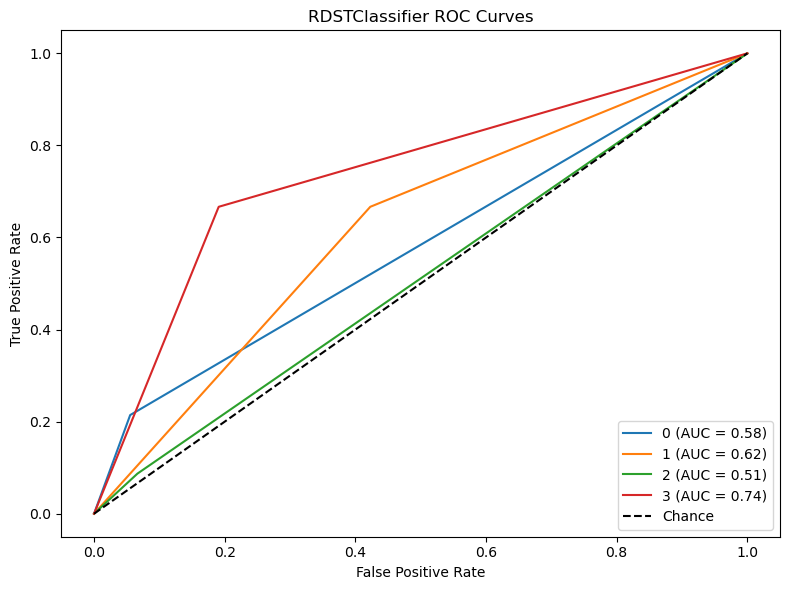

In [27]:
# =============================================================================
# RDSTClassifier with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space ---
param_dist = {
    "max_shapelets": [5000, 10000],
    "shapelet_lengths": [None],
    "proba_normalization": [0.8],
    "alpha_similarity": [0.5],
    "estimator": [None]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=RDSTClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=1,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_3d, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_rdst = rs.best_estimator_
y_pred_rdst = best_rdst.predict(X_test_3d)

print("\n=== RDSTClassifier Test Classification Report ===")
print(classification_report(y_test, y_pred_rdst))

# --- 5) Confusion Matrix ---
cm_rdst = confusion_matrix(y_test, y_pred_rdst)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_rdst, annot=True, fmt="d", cmap="Blues", xticklabels=best_rdst.classes_, yticklabels=best_rdst.classes_)
plt.title("RDSTClassifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes_rdst = best_rdst.classes_
y_test_bin_rdst = label_binarize(y_test, classes=classes_rdst)
y_score_rdst = best_rdst.predict_proba(X_test_3d)

fpr_rdst, tpr_rdst, roc_auc_rdst = {}, {}, {}
for i, cls in enumerate(classes_rdst):
    fpr_rdst[i], tpr_rdst[i], _ = roc_curve(y_test_bin_rdst[:, i], y_score_rdst[:, i])
    roc_auc_rdst[i] = auc(fpr_rdst[i], tpr_rdst[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes_rdst):
    plt.plot(fpr_rdst[i], tpr_rdst[i], label=f"{cls} (AUC = {roc_auc_rdst[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("RDSTClassifier ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 6) dictionary based

### 6.1) IndividualBOSS

[ibos docs](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.classification.dictionary_based.IndividualBOSS.html)

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters (CV): {'word_length': 8, 'window_size': 14, 'norm': False, 'alphabet_size': 4}
Best CV accuracy: 0.3984

=== IndividualBOSS Test Classification Report ===
              precision    recall  f1-score   support

           0       0.30      0.25      0.27        28
           1       0.41      0.45      0.43        78
           2       0.14      0.15      0.15        46
           3       0.46      0.43      0.44        75

    accuracy                           0.36       227
   macro avg       0.33      0.32      0.32       227
weighted avg       0.36      0.36      0.36       227



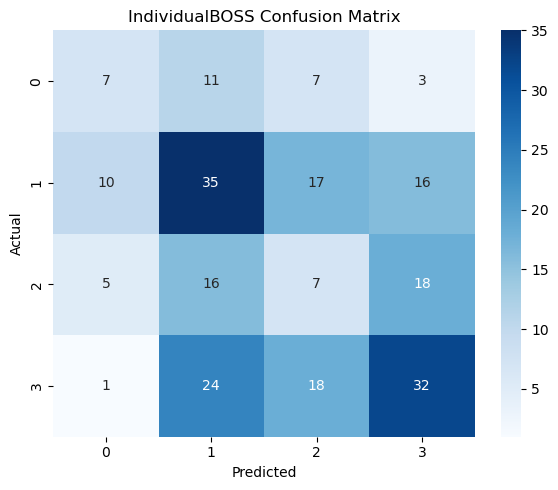

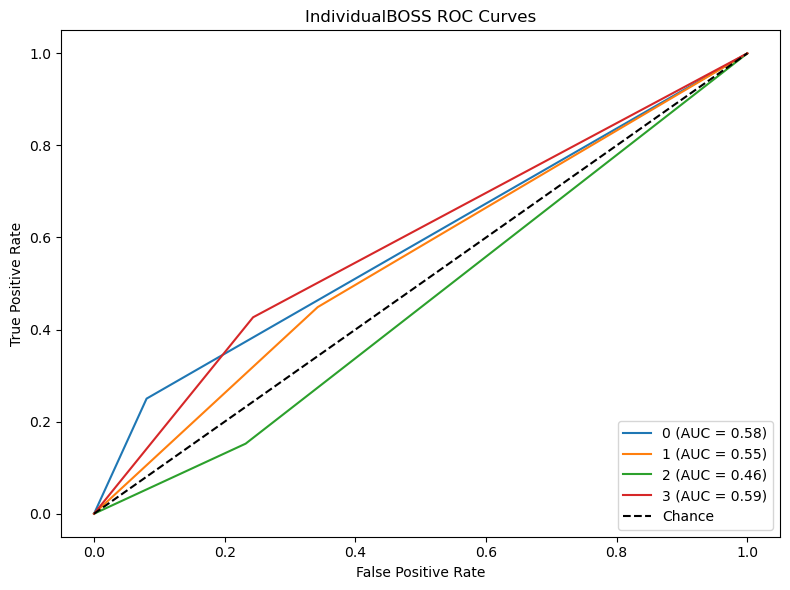

In [28]:
# =============================================================================
# IndividualBOSS with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space for IndividualBOSS ---
param_dist = {
    "window_size": [7, 10, 14, 30],
    "word_length": [6, 8],
    "alphabet_size": [2, 4, 6],
    "norm": [False]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=IndividualBOSS(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    scoring="f1_weighted",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_boss = rs.best_estimator_
y_pred = best_boss.predict(X_test_nested)

print("\n=== IndividualBOSS Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_boss.classes_, yticklabels=best_boss.classes_)
plt.title("IndividualBOSS Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_boss.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_boss.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("IndividualBOSS ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 6.2) BOSSEnsemble

[boss docs](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.classification.dictionary_based.BOSSEnsemble.html)

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameters (CV): {'use_boss_distance': True, 'threshold': 0.92, 'min_window': 14, 'max_win_len_prop': 1, 'max_ensemble_size': 500, 'feature_selection': 'none', 'alphabet_size': 2}
Best CV accuracy: 0.4388

=== BOSSEnsemble Test Classification Report ===
              precision    recall  f1-score   support

           0       0.36      0.14      0.21        28
           1       0.42      0.72      0.53        78
           2       0.25      0.11      0.15        46
           3       0.56      0.48      0.52        75

    accuracy                           0.44       227
   macro avg       0.40      0.36      0.35       227
weighted avg       0.43      0.44      0.41       227



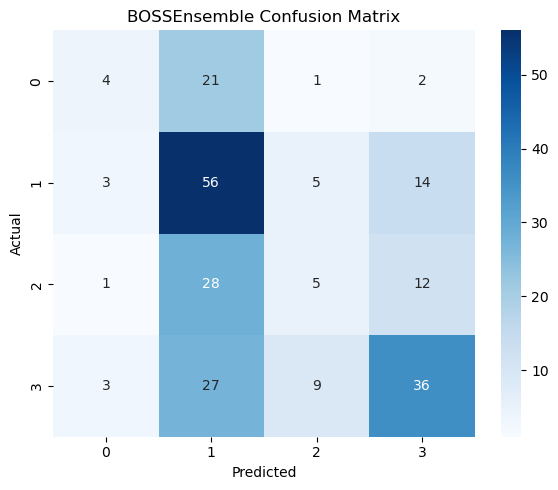

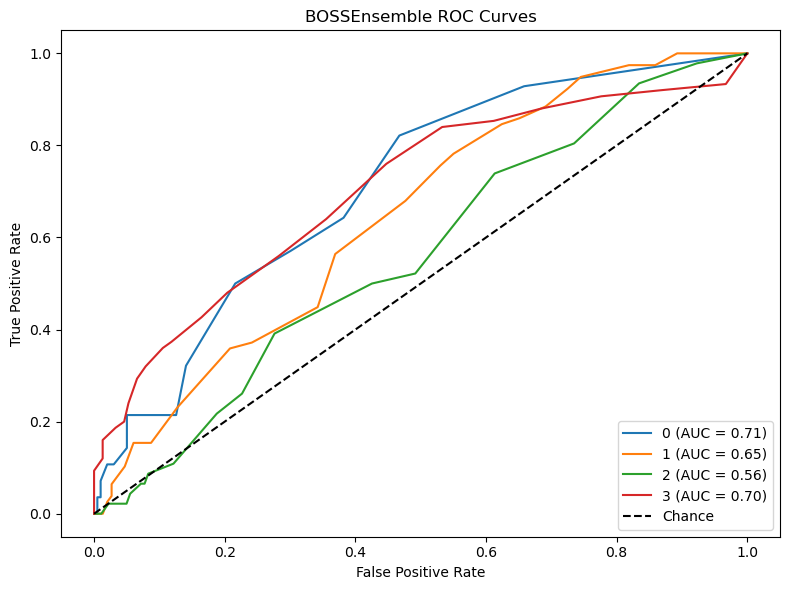

In [29]:
# =============================================================================
# BOSSEnsemble with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space for BOSSEnsemble ---
param_dist = {
    "threshold": [0.92],
    "max_ensemble_size": [500],
    "max_win_len_prop": [1],
    "min_window": [7, 14],
    "feature_selection": ['none'],
    "use_boss_distance": [True],
    "alphabet_size": [2]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=BOSSEnsemble(random_state=42),
    param_distributions=param_dist,
    n_iter=1,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_boss_ensemble = rs.best_estimator_
y_pred = best_boss_ensemble.predict(X_test_nested)

print("\n=== BOSSEnsemble Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_boss_ensemble.classes_, yticklabels=best_boss_ensemble.classes_)
plt.title("BOSSEnsemble Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_boss_ensemble.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_boss_ensemble.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("BOSSEnsemble ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 6.3) SFAFast

[sfast docs](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.transformations.panel.dictionary_based.SFAFast.html)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:262: UserWarning: Feature 1 is constant and will be replaced with 0.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:262: UserWarning: Feature 1 is constant and will be replaced with 0.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:262: UserWarning: Feature 1 is constant and will be replaced with 0.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:262: UserWarning: Feature 1 is constant and will be replaced with 0.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:262: UserWarning: Feature 1 is constant and will be replaced with 0.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:262: UserWarning: Feature 1 is constant and will be replaced


Best parameters (CV): {'sfa__word_length': 8, 'sfa__window_size': 7, 'sfa__remove_repeat_words': False, 'sfa__norm': False, 'sfa__feature_selection': 'chi2', 'sfa__binning_method': 'information-gain', 'sfa__anova': False, 'sfa__alphabet_size': 2, 'knn__n_neighbors': 10}
Best CV accuracy: 0.4829

=== SFAFast + KNN Classification Report ===
              precision    recall  f1-score   support

           0       0.40      0.21      0.28        28
           1       0.47      0.73      0.57        78
           2       0.18      0.07      0.10        46
           3       0.63      0.61      0.62        75

    accuracy                           0.49       227
   macro avg       0.42      0.41      0.39       227
weighted avg       0.45      0.49      0.45       227



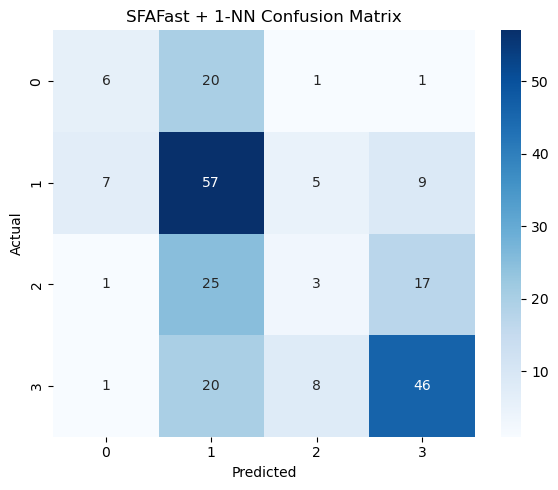

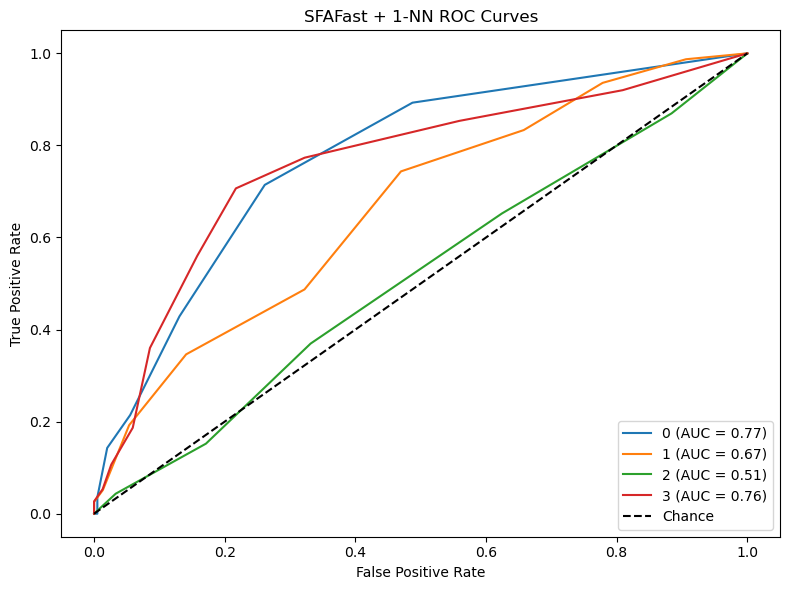

In [30]:
# =============================================================================
# SFAFast (Fast Symbolic Fourier Approximation) + KNeighborsClassifier
# =============================================================================

# 1) Define hyperparameter search space for SFAFast
param_dist = {
    "sfa__word_length": [8, 4, 6],
    "sfa__alphabet_size": [2, 4],
    "sfa__window_size": [12, 14, 7],
    "sfa__binning_method": ["equi-depth", "information-gain", "kmeans"],
    "sfa__norm": [False],
    "sfa__anova": [False],
    "sfa__remove_repeat_words": [False],
    "sfa__feature_selection": ["chi2"],
    "knn__n_neighbors": [10, 20, 30]
}

# 3) Wrap pipeline in RandomizedSearchCV (stratified 3-fold)
rs = RandomizedSearchCV(
    estimator=Pipeline([("sfa", SFAFast(random_state=42)), ("knn", KNeighborsClassifier(metric="manhattan"))]),
    param_distributions=param_dist,
    n_iter=20,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# 4) Fit on nested training set (SFAFast learns its breakpoints; KNN is trained)
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# 5) Final evaluation on the test set
best_pipe = rs.best_estimator_
y_pred = best_pipe.predict(X_test_nested)

print("\n=== SFAFast + KNN Classification Report ===")
print(classification_report(y_test, y_pred))

# 6) Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_pipe.named_steps["knn"].classes_, yticklabels=best_pipe.named_steps["knn"].classes_)
plt.title("SFAFast + 1-NN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 7) ROC Curve & AUC (Multiclass)
classes = best_pipe.named_steps["knn"].classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_pipe.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("SFAFast + 1-NN ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 6.5) MrSEQL

[mrseql docs](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.classification.shapelet_based.MrSEQL.html)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/opt/anaconda3/lib/python3.12/site-packages/sktime/classification/_delegate.py:66: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  estimator.fit(X=X, y=y)
/opt/anaconda3/lib/python3.12/site-packages/sktime/classification/_delegate.py:66: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  estimator.fit(X=X, y=y)
/opt/anaconda3/lib/python3.12/site-packages/sktime/classification/_delegate.py:66: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  estimator.fit(X=X, y=y)
/opt/anaconda3/lib/python3.12/site-packages/sktime/classification/_delegate.py:66: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  estimator.fit(X=X, y=y)
/opt/anaconda3/lib/python3.12/site-packages/sktime/classification/_delegate.py:96: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return estimator.predict(X=X)
/opt/anaconda3/lib/python3.12/site-pack


Best parameters (CV): {'symrep': 'sfa', 'seql_mode': 'clf'}
Best CV accuracy: 0.4432


/opt/anaconda3/lib/python3.12/site-packages/sktime/classification/_delegate.py:96: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return estimator.predict(X=X)



=== MrSEQL Test Classification Report ===
              precision    recall  f1-score   support

           0       0.33      0.04      0.06        28
           1       0.42      0.72      0.53        78
           2       0.21      0.09      0.12        46
           3       0.50      0.48      0.49        75

    accuracy                           0.43       227
   macro avg       0.37      0.33      0.30       227
weighted avg       0.39      0.43      0.38       227



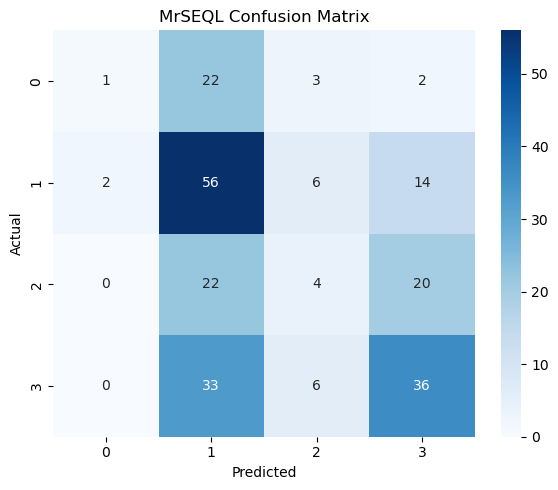

/opt/anaconda3/lib/python3.12/site-packages/sktime/classification/_delegate.py:127: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  return estimator.predict_proba(X=X)


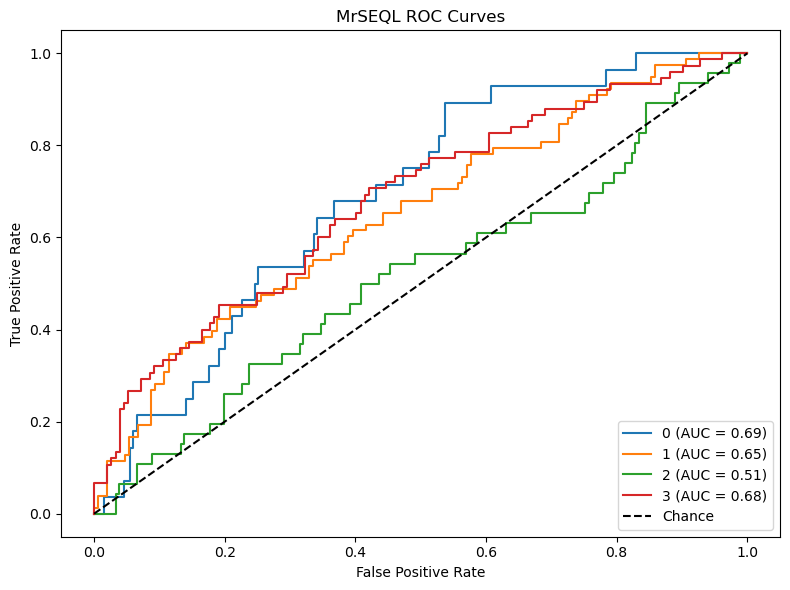

In [31]:
# =============================================================================
# MrSEQL with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space for MrSEQL ---
param_dist = {
    "seql_mode": ["clf", "fs"],
    "symrep": ["sax", "sfa"]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=MrSEQL(),
    param_distributions=param_dist,
    n_iter=4,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_mrseql = rs.best_estimator_
y_pred = best_mrseql.predict(X_test_nested)

print("\n=== MrSEQL Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_mrseql.classes_, yticklabels=best_mrseql.classes_)
plt.title("MrSEQL Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_mrseql.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_mrseql.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("MrSEQL ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 6.6) WEASEL

[weasl docs](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.classification.dictionary_based.WEASEL.html)

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameters (CV): {'window_inc': 2, 'support_probabilities': False, 'feature_selection': 'chi2', 'binning_strategy': 'information-gain', 'bigrams': True, 'anova': True, 'alphabet_size': 4}
Best CV accuracy: 0.4906

=== WEASEL Test Classification Report ===
              precision    recall  f1-score   support

           0       0.44      0.29      0.35        28
           1       0.43      0.56      0.49        78
           2       0.14      0.04      0.07        46
           3       0.58      0.71      0.63        75

    accuracy                           0.47       227
   macro avg       0.40      0.40      0.38       227
weighted avg       0.42      0.47      0.43       227



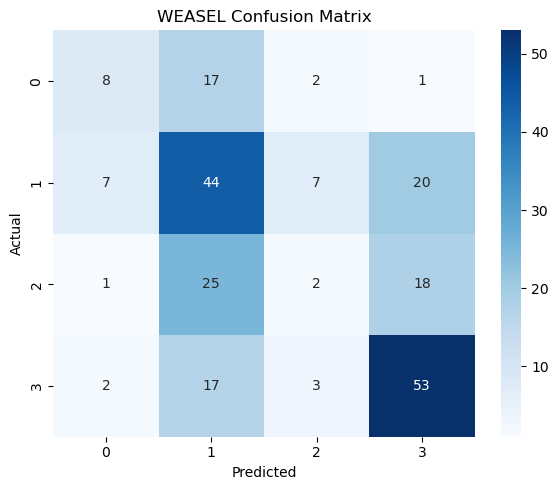

'classes = best_weasel.classes_\ny_test_bin = label_binarize(y_test, classes=classes)\ny_score = best_weasel.predict_proba(X_test_nested)\n\nfpr, tpr, roc_auc = {}, {}, {}\nfor i, cls in enumerate(classes):\n    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])\n    roc_auc[i] = auc(fpr[i], tpr[i])\n\nplt.figure(figsize=(8, 6))\nfor i, cls in enumerate(classes):\n    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")\nplt.plot([0, 1], [0, 1], "k--", label="Chance")\nplt.title("WEASEL ROC Curves")\nplt.xlabel("False Positive Rate")\nplt.ylabel("True Positive Rate")\nplt.legend(loc="lower right")\nplt.tight_layout()\nplt.show()\n'

In [32]:
# =============================================================================
# WEASEL with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space for WEASEL ---
param_dist = {
    "anova": [True],
    "bigrams": [True],
    "binning_strategy": ["information-gain"],
    "window_inc": [2],
    "alphabet_size": [4],
    "feature_selection": ["chi2"],
    "support_probabilities": [False] # -> If set to False, a RidgeClassifierCV will be trained, higher accuracy and is faster but not support predict_proba. If set to True a LogisticRegression will be trained which is slower and less accuracy but support predict_proba()
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=WEASEL(random_state=42),
    param_distributions=param_dist,
    n_iter=1,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_weasel = rs.best_estimator_
y_pred = best_weasel.predict(X_test_nested)

print("\n=== WEASEL Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_weasel.classes_, yticklabels=best_weasel.classes_)
plt.title("WEASEL Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
"""classes = best_weasel.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_weasel.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("WEASEL ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
"""

### 6.6) MUSE

[muse docs](https://www.sktime.net/en/latest/api_reference/auto_generated/sktime.classification.dictionary_based.MUSE.html)

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameters (CV): {'window_inc': 2, 'variance': False, 'support_probabilities': False, 'feature_selection': 'chi2', 'bigrams': True, 'anova': True, 'alphabet_size': 4}
Best CV accuracy: 0.4807

=== MUSE Test Classification Report ===
              precision    recall  f1-score   support

           0       0.43      0.21      0.29        28
           1       0.46      0.60      0.52        78
           2       0.19      0.11      0.14        46
           3       0.48      0.53      0.50        75

    accuracy                           0.43       227
   macro avg       0.39      0.36      0.36       227
weighted avg       0.41      0.43      0.41       227



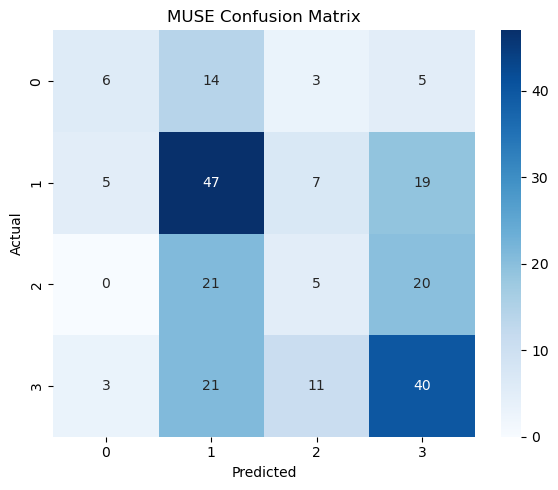

In [33]:
# =============================================================================
# MUSE (Multivariate Unsupervised Symbolic Ensemble) with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space for MUSE ---
param_dist = {
    "anova": [True],
    "variance": [False],
    "bigrams": [True],
    "window_inc": [2],
    "alphabet_size": [4],
    "feature_selection": ["chi2"],
    "support_probabilities": [False] # -> If set to False, a RidgeClassifierCV will be trained, higher accuracy and is faster but not support predict_proba. If set to True a LogisticRegression will be trained which is slower and less accuracy but support predict_proba()
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=MUSE(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_muse = rs.best_estimator_
y_pred = best_muse.predict(X_test_nested)

print("\n=== MUSE Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_muse.classes_, yticklabels=best_muse.classes_)
plt.title("MUSE Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

### 6.6) WEASEL_V2

[weaslv2 docs](https://www.aeon-toolkit.org/en/latest/api_reference/auto_generated/aeon.classification.dictionary_based.WEASEL_V2.html)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/anaconda3/lib/python3.12/site-packages/joblib/parallel.py:1362: UserWarning: The backend class 'SequentialBackend' does not support timeout. You have set 'timeout=99999' in Parallel but the 'timeout' parameter will not be used.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/joblib/parallel.py:1362: UserWarning: The backend class 'SequentialBackend' does not support timeout. You have set 'timeout=99999' in Parallel but the 'timeout' parameter will not be used.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/joblib/parallel.py:1362: UserWarning: The backend class 'SequentialBackend' does not support timeout. You have set 'timeout=99999' in Parallel but the 'timeout' parameter will not be used.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/joblib/parallel.py:1362: UserWarning: The backend class 'SequentialBackend' does not support timeout. You have set 'timeout=99999' in Parallel but the 'timeout' parameter will not be used.
  warnings.warn(



Best parameters (CV): {'word_lengths': (7, 8), 'use_first_differences': (True, False), 'min_window': 4, 'max_feature_count': 30000, 'feature_selection': 'chi2_top_k', 'class_weight': None}
Best CV accuracy: 0.5138

=== WEASEL_V2Classifier (aeon) Test Classification Report ===
              precision    recall  f1-score   support

           0       0.44      0.14      0.22        28
           1       0.43      0.78      0.55        78
           2       0.00      0.00      0.00        46
           3       0.63      0.61      0.62        75

    accuracy                           0.49       227
   macro avg       0.38      0.38      0.35       227
weighted avg       0.41      0.49      0.42       227



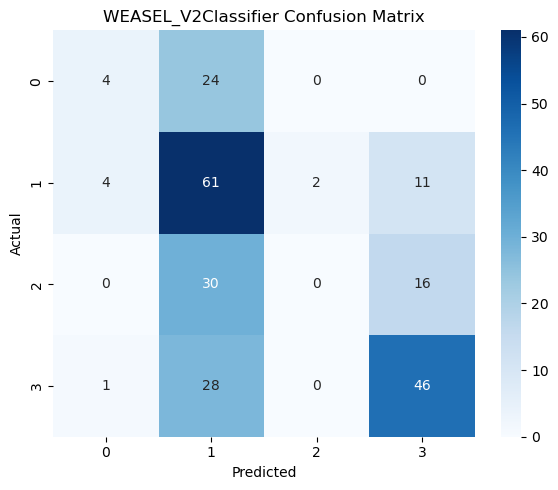

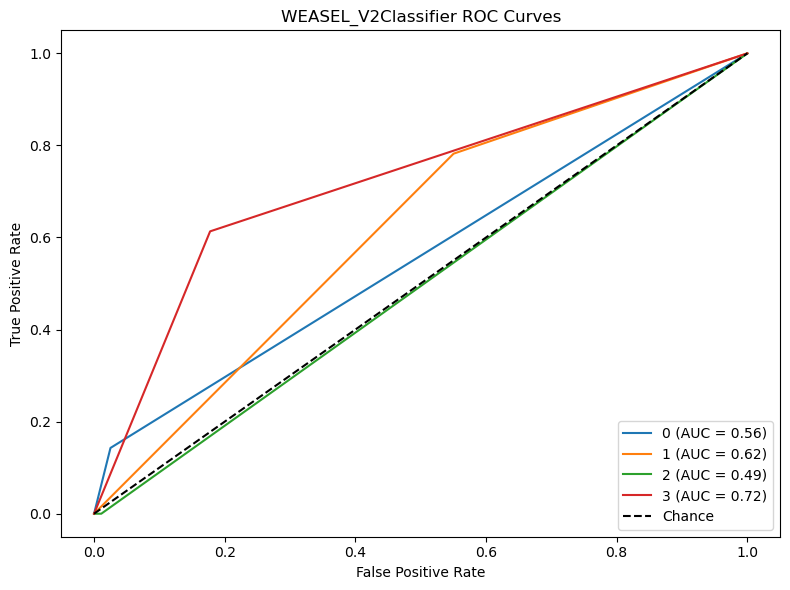

In [34]:
# =============================================================================
# WEASEL_V2 (aeon) with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space for WEASELV2Classifier ---
param_dist = {
    "min_window": [4],
    "word_lengths": [(7, 8)],
    "use_first_differences": [(True, False)],
    "feature_selection": ["chi2_top_k"],
    "max_feature_count": [30000],
    "class_weight": [None]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=WEASEL_V2(random_state=42),
    param_distributions=param_dist,
    n_iter=1,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the 3d training set ---
rs.fit(X_train_3d, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_weasel_v2 = rs.best_estimator_
y_pred = best_weasel_v2.predict(X_test_3d)

print("\n=== WEASEL_V2Classifier (aeon) Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_weasel_v2.classes_, yticklabels=best_weasel_v2.classes_)
plt.title("WEASEL_V2Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_weasel_v2.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_weasel_v2.predict_proba(X_test_3d)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("WEASEL_V2Classifier ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 7) neural

### 7.1) MLPClassifier

[nn docs](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html)

Fitting 1 folds for each of 1 candidates, totalling 1 fits

Best parameters (CV hold‐out): {'warm_start': False, 'validation_fraction': 0.1, 'tol': 0.0001, 'solver': 'adam', 'shuffle': True, 'max_iter': 200, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (128, 64, 32), 'early_stopping': True, 'batch_size': 'auto', 'alpha': 0.0001, 'activation': 'relu'}
Hold‐out accuracy: 0.4890

=== MLPClassifier Test Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.43      0.82      0.57        78
           2       0.00      0.00      0.00        46
           3       0.62      0.65      0.64        75

    accuracy                           0.50       227
   macro avg       0.26      0.37      0.30       227
weighted avg       0.35      0.50      0.40       227



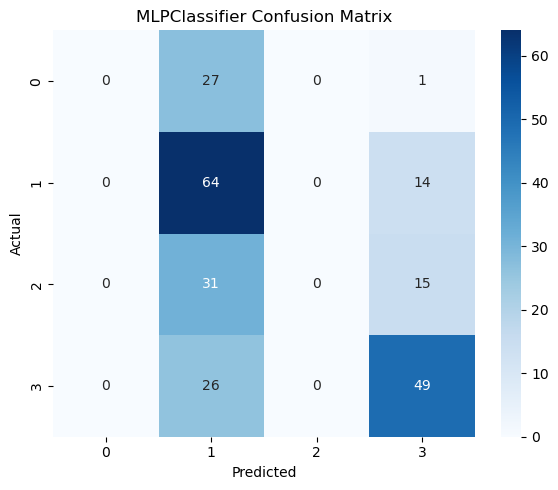

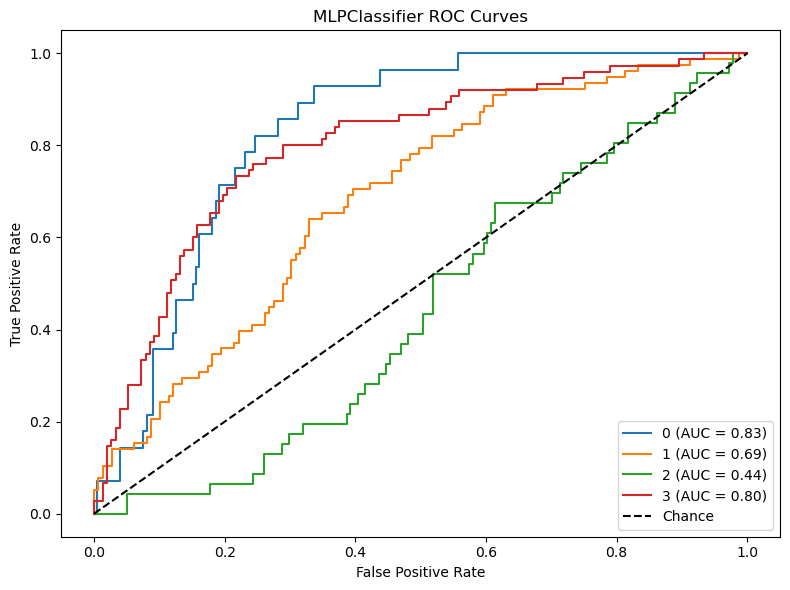

In [35]:
# =============================================================================
# PART DL-1: MLPClassifier on Flattened Series with Single‐Holdout RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space for MLPClassifier ---
param_dist = {
    "hidden_layer_sizes": [(128, 64, 32)],
    "activation": ["relu"],
    "solver": ["adam"],
    "alpha": [0.0001],
    "batch_size": ["auto"],
    "learning_rate_init": [0.001],
    "max_iter": [200],
    "shuffle": [True],
    "tol": [0.0001],
    "warm_start": [False],
    "early_stopping": [True],
    "validation_fraction": [0.1],
}

# --- 2) Use a single test split for CV (20% of training as “validation”) ---
rs = RandomizedSearchCV(
    estimator=MLPClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=3,
    scoring="accuracy",
    cv=StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the flattened training set ---
rs.fit(X_train_raw, y_train)
print(f"\nBest parameters (CV hold‐out): {rs.best_params_}")
print(f"Hold‐out accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the separate test set ---
best_mlp = rs.best_estimator_
y_pred = best_mlp.predict(X_test_raw)

print("\n=== MLPClassifier Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_mlp.classes_, yticklabels=best_mlp.classes_)
plt.title("MLPClassifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_mlp.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_mlp.predict_proba(X_test_raw)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("MLPClassifier ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 7.2) CNNClassifier

[cnn docs](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.classification.deep_learning.CNNClassifier.html)

[early stop](https://keras.io/api/callbacks/early_stopping/)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


2025-06-15 07:08:53.939859: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-15 07:08:53.946519: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-15 07:08:53.947343: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 380, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 90,

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

Best parameters (CV hold‐out): {'use_bias': True, 'padding': 'auto', 'optimizer': None, 'n_epochs': 100, 'n_conv_layers': 2, 'metrics': None, 'loss': 'categorical_crossentropy', 'kernel_size': 7, 'callbacks': [<keras.src.callbacks.early_stopping.EarlyStopping object at 0x1a4dea4b0>], 'batch_size': 16, 'avg_pool_size': 3, 'activation': 'softmax'}
Hold‐out accuracy: 0.4725
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

=== CNNClassifier Test Classification Report ===
              precision    recall  f1-score   support

           0       0.31      0.14      0.20        28
           1       0.43      0.76      0.55        78
           2       0.00      0.00      0.00        46
           3       0.66      0.67      0.66        75

    accuracy                           0.50       227
   macro avg       0.35      0.39      0.35       227
weighted avg       0.40      0.50      0.43       227



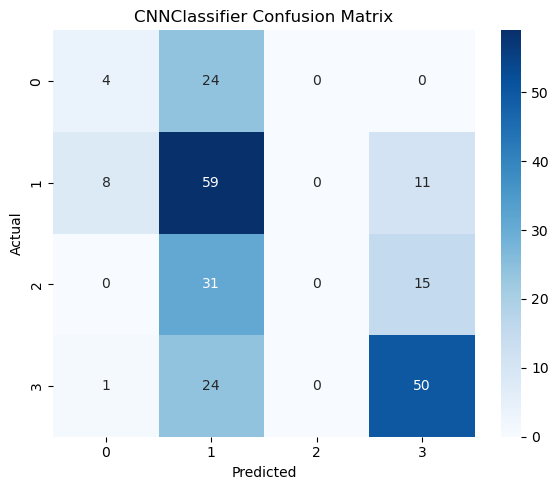

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


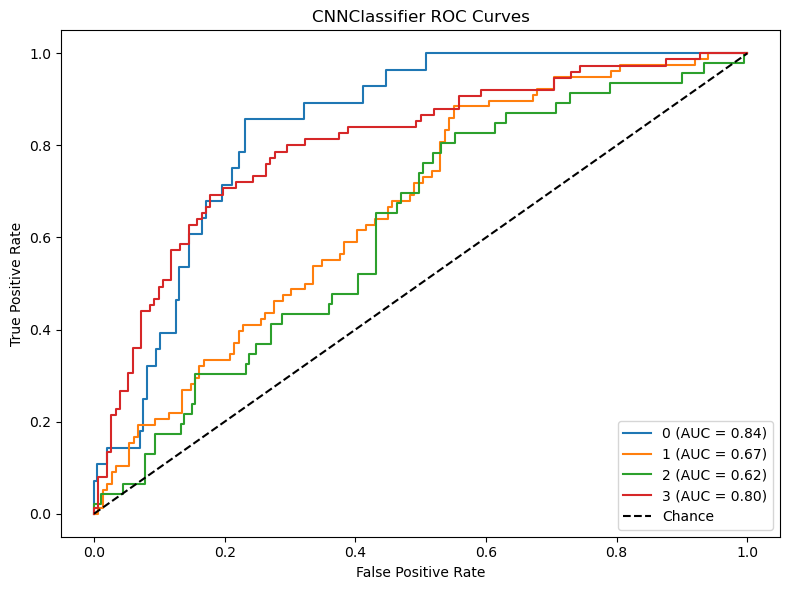

In [36]:
# =============================================================================
# PART DL-2: CNNClassifier (sktime) with Single‐Holdout RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space for CNNClassifier ---
param_dist = {
    "n_epochs": [100],
    "batch_size": [16],
    "kernel_size": [7],
    "avg_pool_size": [3],
    "n_conv_layers": [2],
    "loss": ["categorical_crossentropy"],
    "metrics": [None],
    "callbacks": [[EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)]],
    "activation": ["relu", "sigmoid", "softmax"],
    "use_bias": [True],
    "optimizer": [None],
    "padding": ["auto"],
}

# --- 2) Use a single hold‐out split for validation (20% of training set) ---
rs = RandomizedSearchCV(
    estimator=CNNClassifier(random_state=42, verbose=0),
    param_distributions=param_dist,
    n_iter=3,
    scoring="accuracy",
    cv=StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV hold‐out): {rs.best_params_}")
print(f"Hold‐out accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the separate test set ---
best_cnn = rs.best_estimator_
y_pred = best_cnn.predict(X_test_nested)

print("\n=== CNNClassifier Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_cnn.classes_, yticklabels=best_cnn.classes_)
plt.title("CNNClassifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_cnn.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_cnn.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("CNNClassifier ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 7.3) SimpleRNNClassifier

[rnn docs](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.classification.deep_learning.SimpleRNNClassifier.html)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


2025-06-15 07:09:58.391163: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-15 07:10:03.721346: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-06-15 07:10:03.825619: I tensorflow/core/platform/cpu_feature_guard.cc:210] This 

182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/opt/anaconda3/lib/python3.12/site-packages/sktime/classification/deep_learning/base.py:104: RuntimeWarning: invalid value encountered in divide
  probs = probs / probs.sum(axis=1, keepdims=1)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 949, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 288, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/s

182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
182/182 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Best parameters (CV hold‐out): {'units': 7, 'optimizer': None, 'n_epochs': 100, 'metrics': None, 'loss': 'mean_squared_error', 'callbacks': <keras.src.callbacks.early_stopping.EarlyStopping object at 0x1a4257aa0>, 'batch_size': 1, 'activation': 'softmax'}
Hold‐out accuracy: 0.4780
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

=== SimpleRNNClassifier Test Classification Report ===
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        28
           1       0.45      0.79      0.57        78
           2       0.00      0.00      0.00        46
           3       0.60      0.71      0.65        75

    accuracy                           0.51       227
   macro avg       0.26      0.38      0.31       227
weighted avg       0.35      0.51      0.41       227



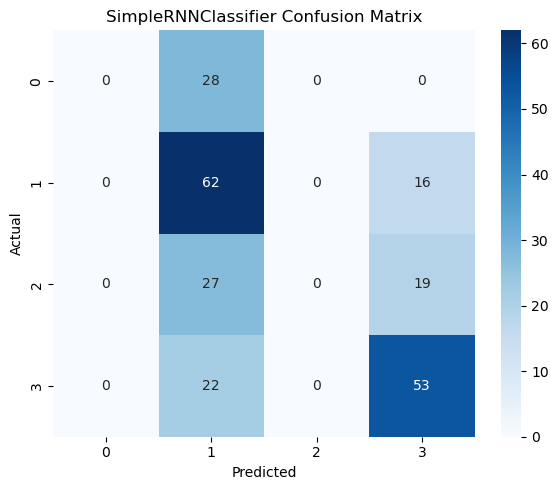

227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


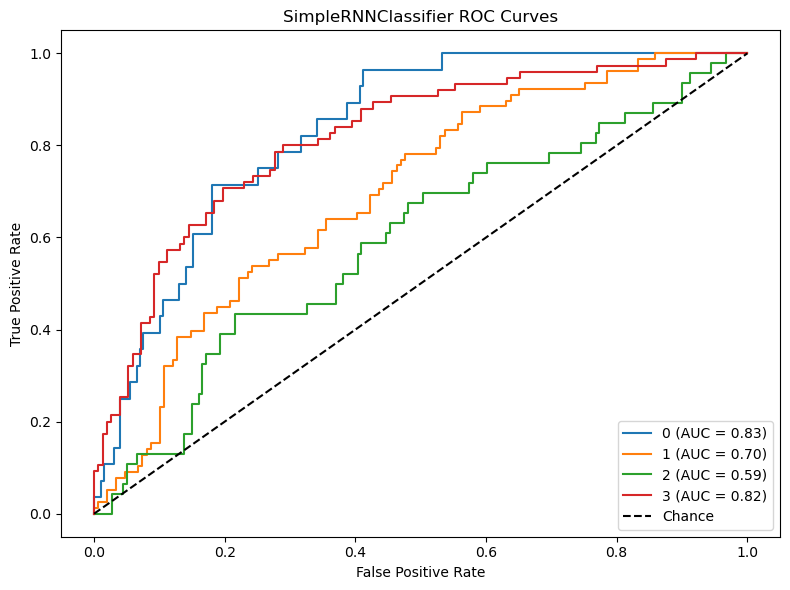

In [37]:
# =============================================================================
# PART DL-3: SimpleRNNClassifier (sktime) with Single‐Holdout RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space for SimpleRNNClassifier ---
param_dist = {
    "n_epochs": [100],
    "batch_size": [1],
    "units": [7],
    "callbacks": [EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)],
    "loss": ["mean_squared_error"],
    "metrics": [None],
    "activation": ["relu", "sigmoid", "softmax"],
    "optimizer": [None],
}

# --- 2) Use a single hold‐out split for validation (20% of training set) ---
rs = RandomizedSearchCV(
    estimator=SimpleRNNClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=3,
    scoring="accuracy",
    cv=StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV hold‐out): {rs.best_params_}")
print(f"Hold‐out accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the separate test set ---
best_rnn = rs.best_estimator_
y_pred = best_rnn.predict(X_test_nested)

print("\n=== SimpleRNNClassifier Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_rnn.classes_, yticklabels=best_rnn.classes_)
plt.title("SimpleRNNClassifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_rnn.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_rnn.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("SimpleRNNClassifier ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 7.4) LSTM

[lstm docs](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)

In [38]:
"""# =============================================================================
# PART DL-8: Custom Keras LSTM Classifier with Single‐Holdout RandomizedSearchCV
# =============================================================================

# Reshape for Keras: (n, 1, 100) → (n, 100, 1)
X_train_lstm = np.transpose(X_train_3d, (0, 2, 1))  # shape: (n_train, 100, 1)
X_test_lstm  = np.transpose(X_test_3d,  (0, 2, 1))  # shape: (n_test,  100, 1)

# --- 1) Define a function to build the Keras LSTM model ---
def create_lstm_model(lstm_units, dropout_rate, learning_rate):
    
    model = Sequential([
        LSTM(lstm_units, input_shape=(100, 1)),
        Dropout(dropout_rate),
        Dense(5, activation="softmax")  # 5 classes for rating_category_ord
    ])
    
    # Use sparse_categorical_crossentropy because y are integer labels 0–4
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    
    return model

# Wrap the model for use in scikit‐learn
keras_clf = KerasClassifier(build_fn=create_lstm_model, verbose=0)

# --- 2) Define hyperparameter search space ---
param_dist = {
    "lstm_units": [64],
    "dropout_rate": [0.3],
    "learning_rate": [1e-3],
    "batch_size": [16],
    "epochs": [20],
}

# --- 3) Use a single hold‐out split for “validation” (20% of training) ---
cv = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)

# --- 4) Set up RandomizedSearchCV ---
rs = RandomizedSearchCV(
    estimator=keras_clf,
    param_distributions=param_dist,
    n_iter=5,               # fewer trials to save time
    scoring="accuracy",
    cv=cv,                  # single hold‐out
    random_state=42,
    n_jobs=1,               # Keras models are not fork‐safe; use 1
    verbose=1
)

# --- 5) Run search on the LSTM‐reshaped training set ---
# Configure EarlyStopping callback to monitor validation loss
early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)

# Pass validation_split and callbacks via fit_params
fit_params = {
    "validation_split": 0.2,
    "callbacks": [early_stopping]
}

rs.fit(X_train_lstm, y_train, **fit_params)
print(f"\nBest parameters (CV hold‐out): {rs.best_params_}")
print(f"Hold‐out accuracy: {rs.best_score_:.4f}")

# --- 6) Final evaluation on the separate test set ---
best_lstm = rs.best_estimator_
y_pred = best_lstm.predict(X_test_lstm)

print("\n=== Keras LSTM Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 7) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=best_lstm.classes_,
    yticklabels=best_lstm.classes_
)
plt.title("Keras LSTM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 8) ROC Curve & AUC (Multiclass) ---
classes = best_lstm.classes_
y_test_bin = label_binarize(y_test, classes=classes)
# predict_proba is available via KerasClassifier
y_score = best_lstm.predict_proba(X_test_lstm)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("Keras LSTM ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()"""

'# =============================================================================\n# PART DL-8: Custom Keras LSTM Classifier with Single‐Holdout RandomizedSearchCV\n# =============================================================================\n\n# Reshape for Keras: (n, 1, 100) → (n, 100, 1)\nX_train_lstm = np.transpose(X_train_3d, (0, 2, 1))  # shape: (n_train, 100, 1)\nX_test_lstm  = np.transpose(X_test_3d,  (0, 2, 1))  # shape: (n_test,  100, 1)\n\n# --- 1) Define a function to build the Keras LSTM model ---\ndef create_lstm_model(lstm_units, dropout_rate, learning_rate):\n    \n    model = Sequential([\n        LSTM(lstm_units, input_shape=(100, 1)),\n        Dropout(dropout_rate),\n        Dense(5, activation="softmax")  # 5 classes for rating_category_ord\n    ])\n    \n    # Use sparse_categorical_crossentropy because y are integer labels 0–4\n    model.compile(\n        optimizer=Adam(learning_rate=learning_rate),\n        loss="sparse_categorical_crossentropy",\n        metri

### 7.5) ResNetClassifier

[resnet docs](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.classification.deep_learning.ResNetClassifier.html)

Fitting 1 folds for each of 1 candidates, totalling 1 fits


2025-06-15 11:08:55.341075: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

Best parameters (CV hold‐out): {'optimizer': None, 'n_epochs': 100, 'metrics': None, 'loss': 'categorical_crossentropy', 'callbacks': None, 'batch_size': 16, 'activation': 'softmax'}
Hold-out accuracy: 0.3297
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step

=== ResNetClassifier Test Classification Report ===
              precision    recall  f1-score   support

           0       0.25      0.21      0.23        28
           1       0.37      0.77      0.50        78
           2       0.33      0.13      0.19        46
           3       0.78      0.24      0.37        75

    accuracy                           0.40       227
   macro avg       0.43      0.34      0.32       227
weighted avg       0.48      0.40      0.36       227



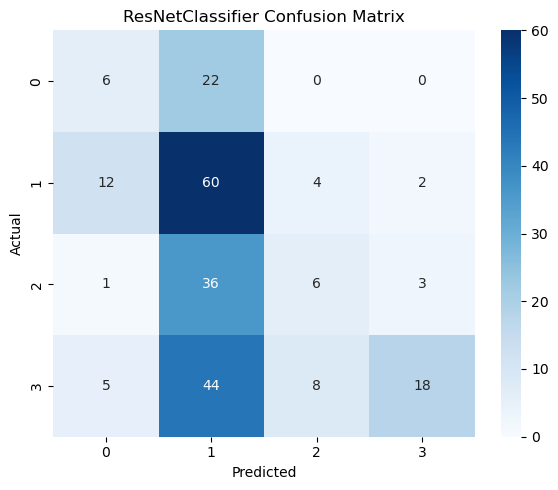

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


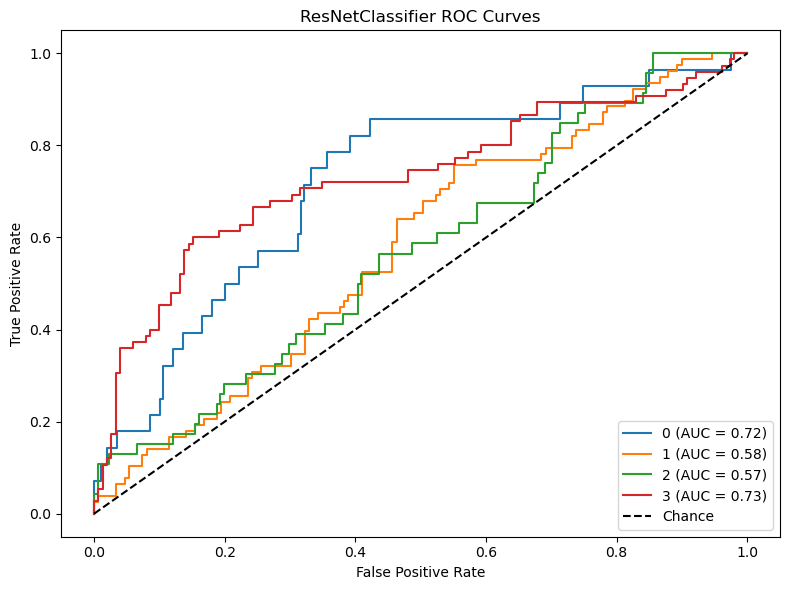

In [40]:
# =============================================================================
# PART DL-4: ResNetClassifier (sktime) with Single‐Holdout RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space for ResNetClassifier ---
param_dist = {
    "n_epochs": [100],
    "loss": ["categorical_crossentropy"],
    "metrics": [None],
    "batch_size": [16],
    "activation": ["softmax"],
    "optimizer": [None],
    "callbacks": [None]
}

# --- 2) Use a single hold‐out split for validation (20% of training set) ---
rs = RandomizedSearchCV(
    estimator=ResNetClassifier(random_state=42, verbose=0),
    param_distributions=param_dist,
    n_iter=1,
    scoring="accuracy",
    cv=StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV hold‐out): {rs.best_params_}")
print(f"Hold-out accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the separate test set ---
best_resnet = rs.best_estimator_
y_pred = best_resnet.predict(X_test_nested)

print("\n=== ResNetClassifier Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_resnet.classes_, yticklabels=best_resnet.classes_)
plt.title("ResNetClassifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_resnet.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_resnet.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("ResNetClassifier ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


### 7.5) InceptionTimeClassifier

[inctime docs](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.classification.deep_learning.InceptionTimeClassifier.html)

Fitting 1 folds for each of 1 candidates, totalling 1 fits


2025-06-15 11:19:14.942066: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step

Best parameters (CV hold‐out): {'n_epochs': 100, 'metrics': None, 'loss': 'categorical_crossentropy', 'kernel_size': 40, 'batch_size': 64}
Hold‐out accuracy: 0.4780
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step

=== InceptionTimeClassifier Test Classification Report ===
              precision    recall  f1-score   support

           0       0.35      0.25      0.29        28
           1       0.52      0.51      0.52        78
           2       0.32      0.26      0.29        46
           3       0.54      0.67      0.60        75

    accuracy                           0.48       227
   macro avg       0.43      0.42      0.42       227
weighted avg       0.47      0.48      0.47       227



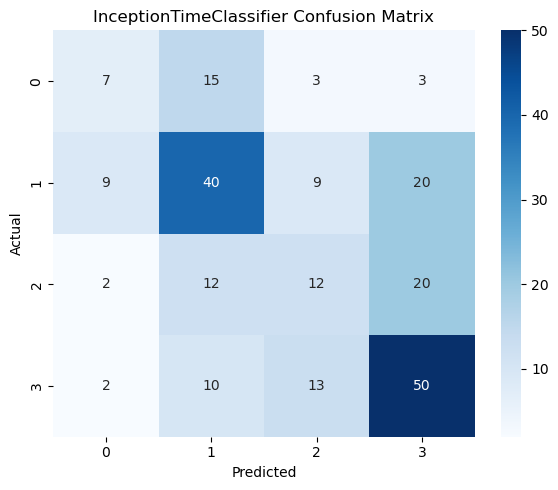

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


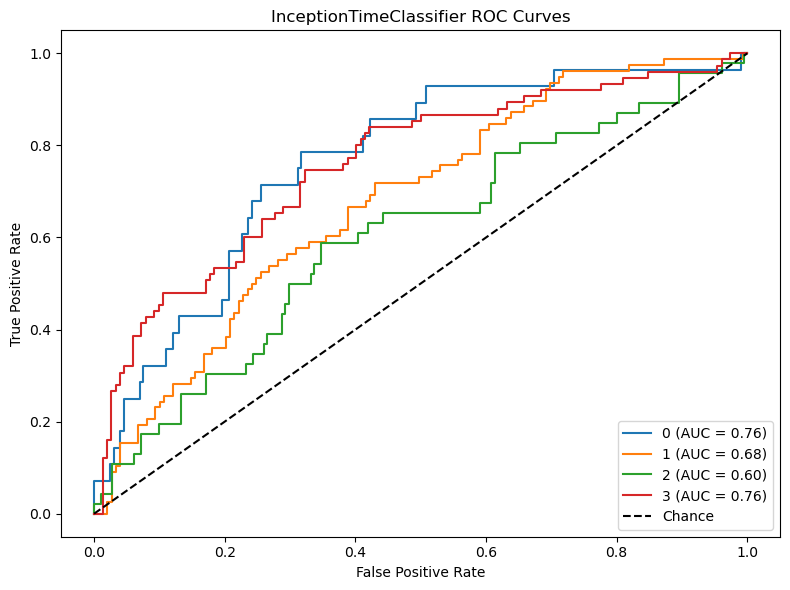

In [41]:
# =============================================================================
# PART DL-5: InceptionTimeClassifier (sktime) with Single‐Holdout RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space for InceptionTimeClassifier ---
param_dist = {
    "n_epochs": [100],
    "batch_size": [64],
    "kernel_size": [40],
    #"n_filters": [32],
    #"use_residual": [True],
    #"use_bottleneck": [True],
    #"bottleneck_size": [32],
    #"depth": [6],
    "loss": ["categorical_crossentropy"],
    "metrics": [None],
}

# --- 2) Use a single hold‐out split for validation (20% of training) ---
rs = RandomizedSearchCV(
    estimator=InceptionTimeClassifier(verbose=0),
    param_distributions=param_dist,
    n_iter=1,
    scoring="accuracy",
    cv=StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV hold‐out): {rs.best_params_}")
print(f"Hold‐out accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the separate test set ---
best_it = rs.best_estimator_
y_pred = best_it.predict(X_test_nested)

print("\n=== InceptionTimeClassifier Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_it.classes_, yticklabels=best_it.classes_)
plt.title("InceptionTimeClassifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_it.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_it.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("InceptionTimeClassifier ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 7.6) LSTMFCNClassifier

[lstmfcn docs](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.classification.deep_learning.LSTMFCNClassifier.html)

Fitting 1 folds for each of 1 candidates, totalling 1 fits


2025-06-15 11:32:45.066374: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 295ms/step

Best parameters (CV hold‐out): {'n_epochs': 100, 'lstm_size': 8, 'kernel_sizes': (8, 5, 3), 'filter_sizes': (128, 256, 128), 'dropout': 0.8, 'callbacks': None, 'batch_size': 128, 'attention': False}
Hold‐out accuracy: 0.4670
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/stepWARNING:tensorflow:5 out of the last 26 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x1ac3fd6c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/funct

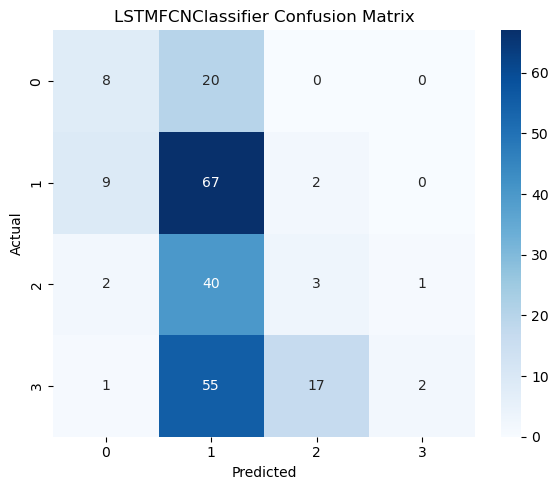

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


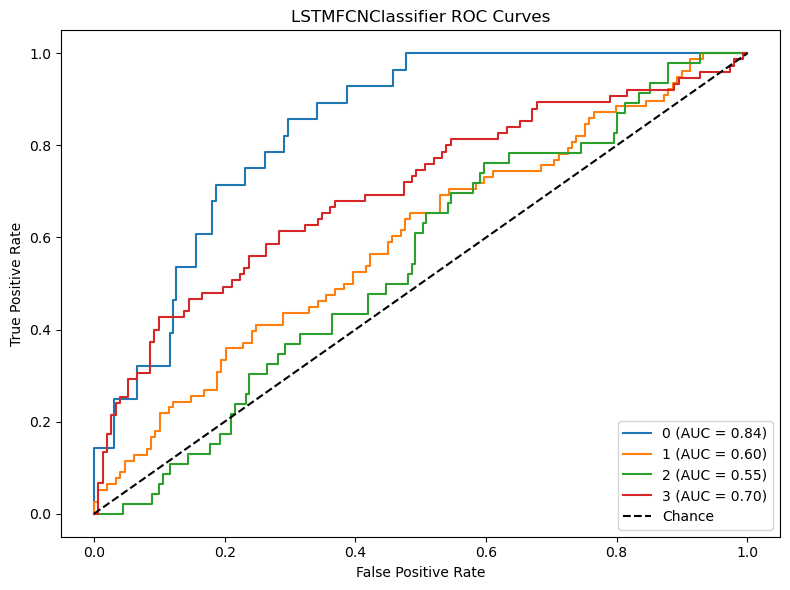

In [42]:
# =============================================================================
# PART DL-6: LSTMFCNClassifier (sktime) with Single‐Holdout RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space for LSTMFCNClassifier ---
param_dist = {
    "n_epochs": [100],
    "batch_size": [128],
    "dropout": [0.8],
    "kernel_sizes": [(8, 5, 3)],
    "filter_sizes": [(128, 256, 128)],
    "lstm_size": [8],
    "attention": [False],
    "callbacks": [None] #=ReduceLRonPlateau
}

# --- 2) Use a single hold‐out split for validation (20% of training) ---
rs = RandomizedSearchCV(
    estimator=LSTMFCNClassifier(verbose=0),
    param_distributions=param_dist,
    n_iter=1,
    scoring="accuracy",
    cv=StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV hold‐out): {rs.best_params_}")
print(f"Hold‐out accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the separate test set ---
best_lf = rs.best_estimator_
y_pred = best_lf.predict(X_test_nested)

print("\n=== LSTMFCNClassifier Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_lf.classes_, yticklabels=best_lf.classes_)
plt.title("LSTMFCNClassifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_lf.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_lf.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("LSTMFCNClassifier ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 7.7) TapNetClassifier

[tapnet docs](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.classification.deep_learning.TapNetClassifier.html)

Fitting 1 folds for each of 1 candidates, totalling 1 fits


2025-06-15 11:36:39.663121: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step

Best parameters (CV hold‐out): {'use_rp': True, 'use_lstm': True, 'use_cnn': True, 'use_bias': True, 'use_att': True, 'rp_params': (-1, 3), 'padding': 'same', 'optimizer': None, 'n_epochs': 100, 'metrics': None, 'loss': 'binary_crossentropy', 'layers': (500, 300), 'kernel_size': (8, 5, 3), 'filter_sizes': (256, 256, 128), 'dropout': 0.5, 'dilation': 1, 'callbacks': <keras.src.callbacks.early_stopping.EarlyStopping object at 0x1ac2c4c20>, 'batch_size': 16, 'activation': 'sigmoid'}
Hold‐out accuracy: 0.3352
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 88ms/step

=== TapNetClassifier Test Classification Report ===
              precision    recall  f1-score   support

           0       0.33      0.04      0.06        28
           1       0.50      0.01      0.03        78
           2       0.00      0.00      0.00        46
           3       0.33      0.99      0.50        75

    accuracy                           0.33       227
   macro avg       0.29      

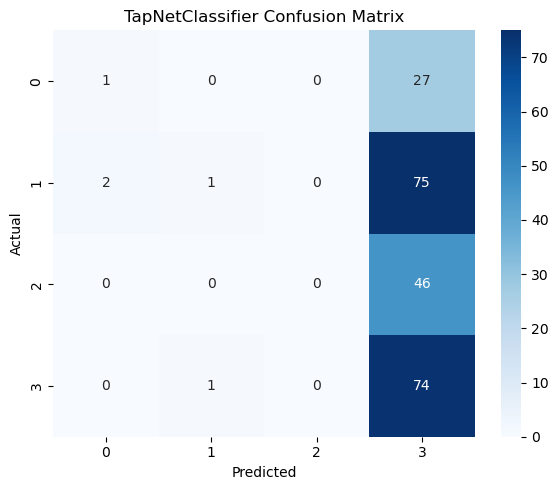

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


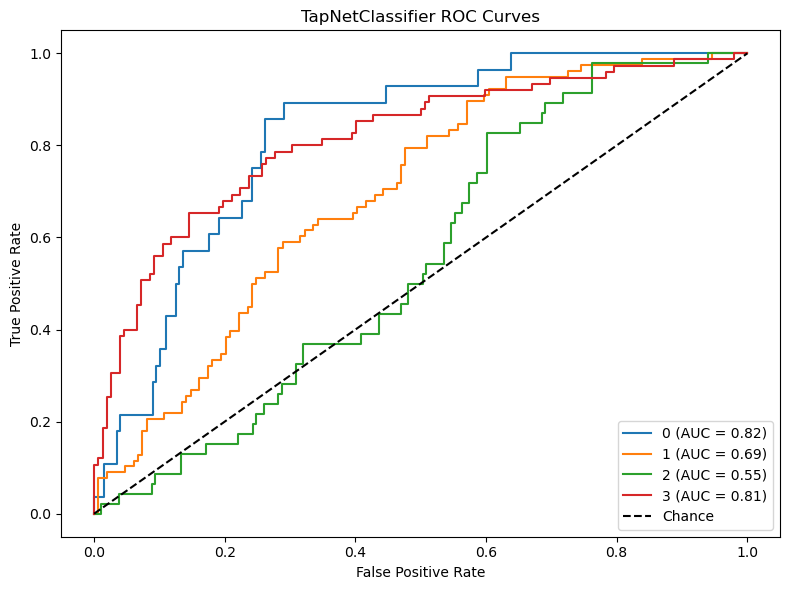

In [43]:
# =============================================================================
# PART DL-7: TapNetClassifier (sktime) with Single‐Holdout RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space for TapNetClassifier ---
param_dist = {
    "n_epochs": [100],
    "batch_size": [16],
    "dropout": [0.5],
    "filter_sizes": [(256, 256, 128)],
    "kernel_size": [(8, 5, 3)],
    "dilation": [1],
    "layers": [(500, 300)],
    "use_rp": [True],
    "rp_params": [(-1, 3)],
    "activation": ["sigmoid"],
    "use_bias": [True],
    "use_att": [True],
    "use_lstm": [True],
    "use_cnn": [True],
    "padding": ["same"],
    "loss": ["binary_crossentropy"],
    "optimizer": [None],
    "metrics": [None],
    "callbacks": [EarlyStopping(monitor="loss", patience=10, restore_best_weights=True)]
}

# --- 2) Use a single hold‐out split for validation (20% of training) ---
rs = RandomizedSearchCV(
    estimator=TapNetClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=1,
    scoring="accuracy",
    cv=StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV hold‐out): {rs.best_params_}")
print(f"Hold‐out accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the separate test set ---
best_tapnet = rs.best_estimator_
y_pred = best_tapnet.predict(X_test_nested)

print("\n=== TapNetClassifier Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_tapnet.classes_, yticklabels=best_tapnet.classes_)
plt.title("TapNetClassifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_tapnet.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_tapnet.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("TapNetClassifier ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 8) kernel based

### 8.1) RocketClassifier

[rok docs](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.classification.kernel_based.RocketClassifier.html)

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameters (CV): {'rocket_transform': 'minirocket', 'num_kernels': 10000, 'max_dilations_per_kernel': 32}
Best CV accuracy: 0.4730

=== RocketClassifier Test Classification Report ===
              precision    recall  f1-score   support

           0       0.45      0.32      0.38        28
           1       0.47      0.67      0.55        78
           2       0.26      0.11      0.15        46
           3       0.62      0.64      0.63        75

    accuracy                           0.50       227
   macro avg       0.45      0.43      0.43       227
weighted avg       0.48      0.50      0.48       227



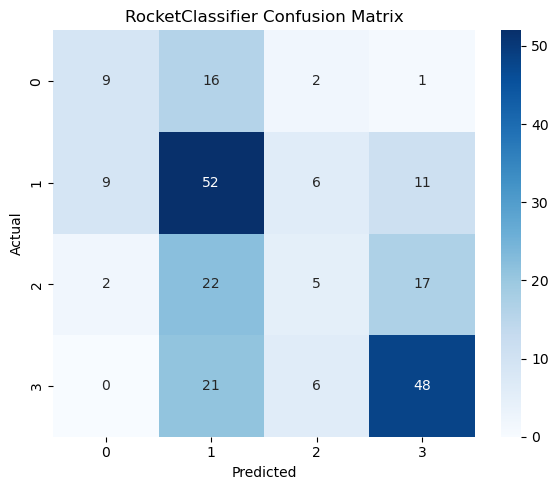

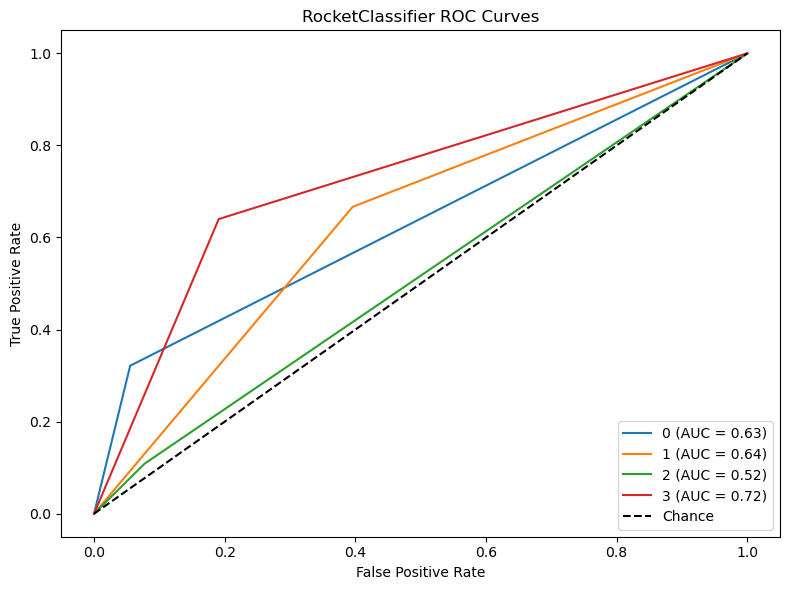

In [44]:
# =============================================================================
# RocketClassifier (sktime) with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space ---
param_dist = {
    "rocket_transform": ["minirocket"],
    "num_kernels": [10000],
    "max_dilations_per_kernel": [32]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=RocketClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=1,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_rocket = rs.best_estimator_
y_pred = best_rocket.predict(X_test_nested)

print("\n=== RocketClassifier Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_rocket.classes_, yticklabels=best_rocket.classes_)
plt.title("RocketClassifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_rocket.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_rocket.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("RocketClassifier ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 8.2) Rocket

[rok docs](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.transformations.panel.rocket.Rocket.html)

Fitting 3 folds for each of 1 candidates, totalling 3 fits

Best parameters (CV): {'rocket__num_kernels': 15000, 'rocket__normalise': False, 'clf__n_neighbors': 20, 'clf__metric': 'euclidean'}
Best CV accuracy: 0.4939

=== Rocket + kNN Test Classification Report ===
              precision    recall  f1-score   support

           0       0.47      0.25      0.33        28
           1       0.45      0.73      0.55        78
           2       0.18      0.04      0.07        46
           3       0.66      0.64      0.65        75

    accuracy                           0.50       227
   macro avg       0.44      0.42      0.40       227
weighted avg       0.46      0.50      0.46       227



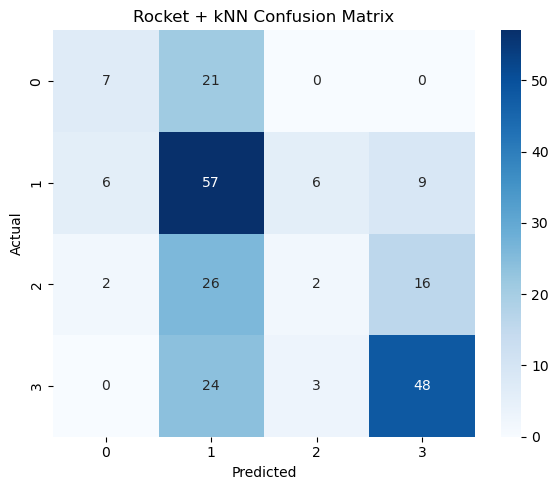

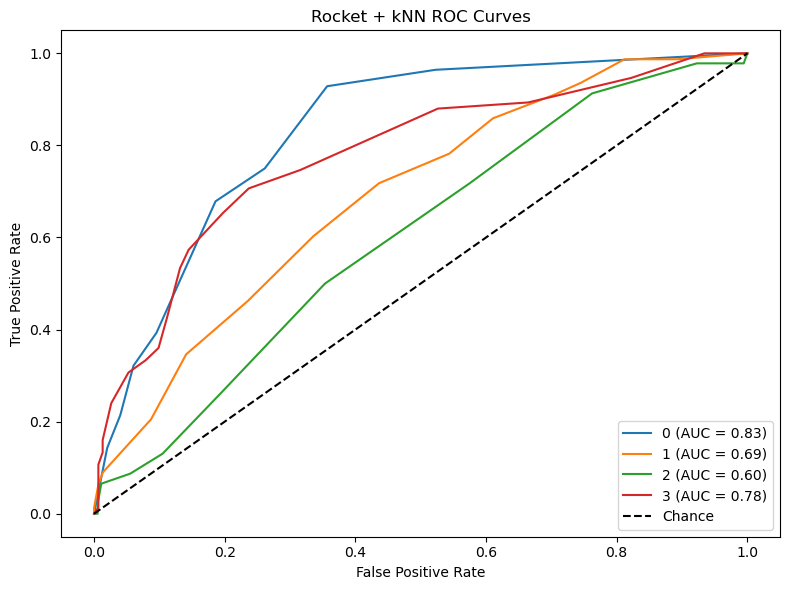

In [45]:
# =============================================================================
# PART K: Rocket Transformer + KNeighborsClassifier with RandomizedSearchCV
# =============================================================================

# --- 2) Define hyperparameter search space ---
param_dist = {
    "rocket__num_kernels": [15000],
    "rocket__normalise": [False],
    "clf__n_neighbors": [20],
    "clf__metric": ["euclidean"]
}

# --- 3) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=Pipeline([("rocket", Rocket(random_state=42)), ("clf", KNeighborsClassifier())]),
    param_distributions=param_dist,
    n_iter=1,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 4) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 5) Final evaluation on the test set ---
best_model = rs.best_estimator_
y_pred = best_model.predict(X_test_nested)

print("\n=== Rocket + kNN Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 6) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_model.named_steps["clf"].classes_, yticklabels=best_model.named_steps["clf"].classes_)
plt.title("Rocket + kNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 7) ROC Curve & AUC (Multiclass) ---
classes = best_model.named_steps["clf"].classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_model.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("Rocket + kNN ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### 9) hybrid/meta-ensemble

### 9.1) HIVECOTEV2

[hive docs](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.classification.hybrid.HIVECOTEV2.html)

*utilizza*:
- [ShapeletTransformClassifier](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.classification.shapelet_based.ShapeletTransformClassifier.html)
- [DrCIF](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.classification.interval_based.DrCIF.html)
- [Arsenal](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.classification.kernel_based.Arsenal.html)
- [TemporalDictionaryEnsemble](https://www.sktime.net/en/stable/api_reference/auto_generated/sktime.classification.dictionary_based.TemporalDictionaryEnsemble.html)

In [49]:
# =============================================================================
# HIVE COTEV2 with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space for HIVE COTEV2 ---
param_dist = {
    "stc_params": [None],
    "drcif_params": [None],
    "arsenal_params": [None],
    "tde_params": [None]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=HIVECOTEV2(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=1,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_hive = rs.best_estimator_
y_pred = best_hive.predict(X_test_nested)

print("\n=== HIVE COTEV2 Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_hive.classes_, yticklabels=best_hive.classes_)
plt.title("HIVE COTEV2 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_hive.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_hive.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("HIVE COTEV2 ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 1 candidates, totalling 3 fits


KeyboardInterrupt: 

### 9.2) MultiRocketHydraClassifier

[hydra docs](https://www.aeon-toolkit.org/en/latest/api_reference/auto_generated/aeon.classification.convolution_based.MultiRocketHydraClassifier.html)

In [47]:
"""# =============================================================================
# MultiRocketHydraClassifier (aeon) with RandomizedSearchCV
# =============================================================================

# --- 1) Define hyperparameter search space for MultiRocketHydraClassifier ---
param_dist = {
    "n_kernels": [5],
    "n_groups": [50]
}

# --- 2) Set up RandomizedSearchCV with stratified folds ---
rs = RandomizedSearchCV(
    estimator=MultiRocketHydraClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=1,
    scoring="accuracy",
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# --- 3) Run search on the nested training set ---
rs.fit(X_train_nested, y_train)
print(f"\nBest parameters (CV): {rs.best_params_}")
print(f"Best CV accuracy: {rs.best_score_:.4f}")

# --- 4) Final evaluation on the test set ---
best_mrh = rs.best_estimator_
y_pred = best_mrh.predict(X_test_nested)

print("\n=== MultiRocketHydraClassifier Test Classification Report ===")
print(classification_report(y_test, y_pred))

# --- 5) Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_mrh.classes_, yticklabels=best_mrh.classes_ )
plt.title("MultiRocketHydraClassifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# --- 6) ROC Curve & AUC (Multiclass) ---
classes = best_mrh.classes_
y_test_bin = label_binarize(y_test, classes=classes)
y_score = best_mrh.predict_proba(X_test_nested)

fpr, tpr, roc_auc = {}, {}, {}
for i, cls in enumerate(classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    plt.plot(fpr[i], tpr[i], label=f"{cls} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], "k--", label="Chance")
plt.title("MultiRocketHydraClassifier ROC Curves")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()"""

'# =============================================================================\n# MultiRocketHydraClassifier (aeon) with RandomizedSearchCV\n# =============================================================================\n\n# --- 1) Define hyperparameter search space for MultiRocketHydraClassifier ---\nparam_dist = {\n    "n_kernels": [5],\n    "n_groups": [50]\n}\n\n# --- 2) Set up RandomizedSearchCV with stratified folds ---\nrs = RandomizedSearchCV(\n    estimator=MultiRocketHydraClassifier(random_state=42, n_jobs=-1),\n    param_distributions=param_dist,\n    n_iter=1,\n    scoring="accuracy",\n    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),\n    random_state=42,\n    n_jobs=-1,\n    verbose=1\n)\n\n# --- 3) Run search on the nested training set ---\nrs.fit(X_train_nested, y_train)\nprint(f"\nBest parameters (CV): {rs.best_params_}")\nprint(f"Best CV accuracy: {rs.best_score_:.4f}")\n\n# --- 4) Final evaluation on the test set ---\nbest_mrh = rs.best_estimator_